In [57]:
#cell 1

import pandas as pd


# 1. Define the filename (make sure you renamed it!)

#samuel 
#file_path = r"C:\Users\20202917\Downloads\nv1fehuuii7o8hjb.csv"

#sid 
file_path = "/Users/siddharth/Downloads/crsp_stock_returns_1985_2024.csv" # Or the new name if you renamed it

# 2. Read only the first 5 rows to see the columns
df_preview = pd.read_csv(file_path, nrows=5)

# 3. Show the columns and the first few rows
print("Columns in the file:")
print(df_preview.columns.tolist())

print("\nFirst 5 rows of data:")
display(df_preview)

Columns in the file:
['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP', 'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT', 'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT', 'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG', 'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM', 'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD', 'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'ALTPRC', 'SPREAD', 'ALTPRCDT', 'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']

First 5 rows of data:


,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACSHR,ALTPRC,SPREAD,ALTPRCDT,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.5625,NaN,1986-01-07,NaN,0.043061,0.040080,0.028021,0.026355,0.045061
1,10000,1986-01-31,1986-12-03,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.3750,0.250,1986-01-31,C,0.009830,0.008007,0.044071,0.043082,0.002367
2,10000,1986-02-28,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.2500,0.250,1986-02-28,-0.257143,0.072501,0.068191,0.060381,0.058938,0.071489
3,10000,1986-03-31,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.4375,0.125,1986-03-31,0.365385,0.053887,0.051362,0.047192,0.045679,0.052794
4,10000,1986-04-30,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.0000,0.250,1986-04-30,-0.098592,-0.007903,-0.009634,0.016140,0.015141,-0.014148


In [58]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [59]:
#cell 2
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [60]:
#cell 3 (REPLACE ENTIRE CELL)

import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# --- Load GPR ---
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Index by month
df = df.set_index("month")

# Optional: simple change series (not the main shock)
df["gpr_change"] = df["GPR"].diff()

# --- AR(1) innovation: GPR_t = c + phi*GPR_{t-1} + u_t ---
gpr = df["GPR"]
gpr_lag = gpr.shift(1).rename("GPR_lag")   # IMPORTANT: give lag a unique name

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan

min_obs = 36  # expanding window min history

for i in range(min_obs, len(df)):
    # Use data up to t-1
    train = pd.concat([gpr.iloc[:i], gpr_lag.iloc[:i]], axis=1).dropna()
    y = train["GPR"]
    X = sm.add_constant(train["GPR_lag"])

    model = sm.OLS(y, X).fit()

    # One-step-ahead forecast for time t (uses only GPR_{t-1})
    X_t = pd.DataFrame({"const": [1.0], "GPR_lag": [gpr_lag.iloc[i]]})
    gpr_hat_t = float(model.predict(X_t).iloc[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# --- Standardize shocks using ONLY info known at t-1 ---
mu_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).mean().shift(1)
sd_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - mu_shk) / sd_shk

mu_chg = df["gpr_change"].expanding(min_periods=min_obs).mean().shift(1)
sd_chg = df["gpr_change"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_change_z"] = (df["gpr_change"] - mu_chg) / sd_chg

# --- Merge table with month-end date column ---
df_gpr_merge = df.reset_index().rename(columns={"month": "date"})
df_gpr_merge["date"] = pd.to_datetime(df_gpr_merge["date"], errors="coerce") + MonthEnd(0)

df_gpr_merge = df_gpr_merge[
    ["date", "GPR", "gpr_change", "gpr_change_z", "gpr_ar1_pred", "gpr_news_shock", "gpr_news_shock_z"]
].dropna(subset=["gpr_news_shock_z"]).sort_values("date").reset_index(drop=True)

print("GPR merge table ready:", df_gpr_merge.shape)
display(df_gpr_merge.tail())


GPR merge table ready: (420, 7)


,date,GPR,gpr_change,gpr_change_z,gpr_ar1_pred,gpr_news_shock,gpr_news_shock_z
415,2025-08-31,136.759415,1.755157,0.047619,126.131691,10.627724,0.315378
416,2025-09-30,124.114983,-12.644432,-0.359158,127.436132,-3.321149,-0.086007
417,2025-10-31,154.425201,30.310219,0.855632,118.259686,36.165515,1.050500
418,2025-11-30,105.251610,-49.173592,-1.393598,140.342169,-35.090559,-1.002426
419,2025-12-31,127.319107,22.067497,0.623270,104.585471,22.733636,0.663749


In [61]:
#cell 4
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import pandas_datareader.data as web

# --- 1. Load & Clean Stock Data (The "Samuel + Pro" Version) ---
print("Loading and cleaning stock data...")

# We ADD 'shrcd' to the columns we need to load
cols_needed = ['permno', 'date', 'ret', 'prc', 'shrout', 'siccd', 'dlret', 'shrcd', 'spread', 'vol']


df_stocks_clean = pd.read_csv(
    file_path, 
    usecols=lambda x: x.lower() in cols_needed, 
    low_memory=False
)
df_stocks_clean.columns = df_stocks_clean.columns.str.lower()

# --- SAMUEL'S FILTER: Keep only Common Shares (10 & 11) ---
print(f"Rows before filter: {len(df_stocks_clean)}")
df_stocks_clean = df_stocks_clean[df_stocks_clean['shrcd'].isin([10, 11])].copy()
print(f"Rows after keeping only Common Shares (10, 11): {len(df_stocks_clean)}")

# Fix Dates
df_stocks_clean['date'] = pd.to_datetime(df_stocks_clean['date'], errors='coerce') + MonthEnd(0)

# Force Numeric Types
for col in ['ret', 'dlret', 'prc', 'shrout', 'spread', 'vol']:
    df_stocks_clean[col] = pd.to_numeric(df_stocks_clean[col], errors='coerce')


# --- Calculate "True" Returns (Delisting Adjustment) ---
# df_stocks_clean['ret'] = df_stocks_clean['ret'].fillna(0)
# df_stocks_clean['dlret'] = df_stocks_clean['dlret'].fillna(0)
# df_stocks_clean['ret_adj'] = (1 + df_stocks_clean['ret']) * (1 + df_stocks_clean['dlret']) - 1

# --- Calculate "True" Returns (Delisting Adjustment) WITHOUT fake 0% months ---

ret = df_stocks_clean['ret']
dlret = df_stocks_clean['dlret']

# If RET exists, combine it with DLRET (missing DLRET treated as 0)
ret_adj = (1 + ret) * (1 + dlret.fillna(0)) - 1

# If RET is missing but DLRET exists (delisting month), use DLRET
mask_delist_only = ret.isna() & dlret.notna()
ret_adj.loc[mask_delist_only] = dlret.loc[mask_delist_only]

# If both are missing, keep NaN (we will drop)
mask_both_missing = ret.isna() & dlret.isna()
ret_adj.loc[mask_both_missing] = np.nan

df_stocks_clean['ret_adj'] = ret_adj

# Drop missing ret_adj (removes the fake 0% return months)
df_stocks_clean = df_stocks_clean.dropna(subset=['ret_adj'])

# --- Winsorize returns BY MONTH (1% / 99%) to kill extreme outliers ---
# This prevents crazy months like +2658% from destroying betas and hedge regressions.

lo = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.01))
hi = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.99))

df_stocks_clean['ret_adj'] = df_stocks_clean['ret_adj'].clip(lower=lo, upper=hi)

print("After winsorization:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())


# --- Calculate Market Cap ---
df_stocks_clean['mktcap'] = df_stocks_clean['prc'].abs() * df_stocks_clean['shrout']

# Drop invalid rows
df_stocks_clean = df_stocks_clean.dropna(subset=['permno', 'date', 'ret_adj', 'mktcap'])

print("Stock data cleaned successfully.")

# --- 2. Get Fama-French Factors ---
# (This part stays the same, just re-running to be safe)
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]
mom = mom.reset_index().rename(columns={'Date': 'date'})
mom[['Mom']] = mom[['Mom']] / 100.0
mom['date'] = mom['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom, on='date', how='inner')

# --- 3. Merge Everything ---
# Ensure df_gpr_merge is ready (from your previous GPR step)
# if 'df_gpr_merge' not in globals():
    # Fallback if variable name was lost, assuming 'df' is your GPR dataframe
  #  df_gpr_merge = df.copy()
   # df_gpr_merge = df_gpr_merge.rename(columns={'month': 'date'})
    #df_gpr_merge['date'] = pd.to_datetime(df_gpr_merge['date']) + MonthEnd(0)

df_master_clean = df_stocks_clean.merge(factors, on='date', how='inner')
df_master_clean = df_master_clean.merge(df_gpr_merge[['date', 'gpr_news_shock_z']], on='date', how='inner')
df_master_clean['excret'] = df_master_clean['ret_adj'] - df_master_clean['RF']
df_master_clean = df_master_clean.dropna(subset=['gpr_news_shock_z'])

print("After ret_adj fix:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())

print("Master dataset ready with Common Shares only!")

print("Market Cap Statistics:")
print(df_master_clean['mktcap'].describe())
print(f"\nSample mktcap values:")
print(df_master_clean[['prc', 'shrout', 'mktcap']].head(10))

# =============================================================================
# ENHANCED LIQUIDITY FILTERING: VOLUME + SPREAD + MARKET CAP
# =============================================================================

print(f"\n=== LIQUIDITY FILTERING ===")
print(f"Before filtering: {len(df_master_clean):,} observations")

original_count = len(df_master_clean)

#  MARKET CAP Filter: $10M (mktcap is in THOUSANDS)
min_mktcap = 10000  # $10M in thousands
df_master_clean = df_master_clean[df_master_clean['mktcap'] >= min_mktcap]
print(f"After market cap filter (>$10M): {len(df_master_clean):,} observations")

# Print Summary Statistics
print(f"\n--- Liquidity Metrics (Post-Filter) ---")
print(f"Median Market Cap: ${df_master_clean['mktcap'].median()/1e3:.1f}M")
print(f"\nTotal data reduction: {(1 - len(df_master_clean)/original_count)*100:.1f}% excluded")

# Clean up
print(f"\nFinal analysis sample: {len(df_master_clean):,} observations")

Loading and cleaning stock data...
Rows before filter: 3720048
Rows after keeping only Common Shares (10, 11): 2513725
After winsorization:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Stock data cleaned successfully.


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/1485974529.py:83: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/1485974529.py:83: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/1485974529.py:88: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object'

After ret_adj fix:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Master dataset ready with Common Shares only!
Market Cap Statistics:
count    2.004496e+06
mean     3.715103e+06
std      3.001042e+07
min      1.056250e+01
25%      4.704650e+04
50%      2.124898e+05
75%      1.109880e+06
max      3.785304e+09
Name: mktcap, dtype: float64

Sample mktcap values:
      prc  shrout     mktcap
0   9.625  1054.0  10144.750
1   9.750  1054.0  10276.500
2   9.500  1054.0  10013.000
3  -9.875  1054.0  10408.250
4  -9.875  1054.0  10408.250
5  10.500  1073.0  11266.500
6  10.125  1073.0  10864.125
7  11.500  1073.0  12339.500
8  11.500  1073.0  12339.500
9  13.000  1073.0  13949.000

=== LIQUIDITY FILTERING ===
Before filtering: 2,004,496 observations
After market cap filter (>$10M): 1,867,493 observations

--- Liquidity Metrics (Post-Filter) ---
Median Market Cap: $259.6M

Total data reduction: 6.8% excluded

Final analysis sample: 1,867,493 observations


In [62]:
# --- REPLACEMENT FOR CELL 5 ---
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Step 1: Estimate Firm-Level Sensitivity (Hollstein EWMA Beta) ---

print("Preparing data for EWMA regression...")

# 1. Sort to ensure rolling window looks at the PAST
df_master_clean = df_master_clean.sort_values(['permno', 'date'])

# 2. Define Exponential Weights (Half-life ~ 2 years for 60m window)
# Hollstein suggests placing higher weight on recent data.
window_size = 36
decay_alpha = 1 - np.exp(np.log(0.5) / 12) # Approx 24-month half-life
weights_template = np.array([(1 - decay_alpha)**i for i in range(window_size)][::-1])

# 3. Define the Rolling WLS Function
def rolling_ewma_beta_pipeline(group):
    # Requirements
    exog_vars = ['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock_z']
    min_obs = 24
    
    # Extract data arrays for speed
    Y = group['excret'].values
    X = group[exog_vars].values
    X = np.column_stack([np.ones(len(X)), X]) # Add constant
    
    # Pre-allocate output array
    # We return a Series with the same index as the group to align perfectly
    betas = np.full(len(Y), np.nan)
    ses = np.full(len(Y), np.nan)
    
    # If not enough data, return NaNs
    if len(Y) < min_obs:
        return pd.DataFrame({'beta_gpr': betas, 'beta_se': ses}, index=group.index)
    
    # Rolling Loop (Manual WLS for speed)
    for t in range(min_obs, len(Y) + 1):
        # Slice window
        start = max(0, t - window_size)
        y_window = Y[start:t]
        x_window = X[start:t]
        
        # Get appropriate weights (tailored to window length if < 60)
        curr_len = len(y_window)
        w = weights_template[-curr_len:] 
        
        # WLS Logic: Multiply X and Y by sqrt(weights)
        sqrt_w = np.sqrt(w)
        X_w = x_window * sqrt_w[:, None]
        y_w = y_window * sqrt_w
        
        try:
            # Fit OLS on weighted data
            # (X'X)^-1 X'Y
            xtx = X_w.T @ X_w
            xtx_inv = np.linalg.pinv(xtx)
            params = xtx_inv @ (X_w.T @ y_w)
            
            # Extract GPR beta (last column in exog_vars + constant is index 5)
            # Const(0), Mkt(1), SMB(2), HML(3), Mom(4), GPR(5)
            betas[t-1] = params[5]
            
            # Calculate SE
            residuals = y_w - X_w @ params
            mse = np.sum(residuals**2) / (curr_len - X_w.shape[1])
            cov_params = mse * xtx_inv
            ses[t-1] = np.sqrt(cov_params[5, 5])
            
        except np.linalg.LinAlgError:
            continue
            
    return pd.DataFrame({'beta_gpr': betas, 'beta_se': ses}, index=group.index)

print("Starting EWMA Rolling Beta estimation. This handles the 'Step 1' Methodology...")
print("Note: This loops manually to apply weights correctly, so it might take 2-3 minutes.")

# 4. Apply
tmp_ewma = df_master_clean.groupby('permno', group_keys=False).apply(rolling_ewma_beta_pipeline)

# 5. Clean Join (Remove old columns if they exist to prevent duplicates)
cols_to_drop = ['beta_gpr', 'beta_se', 'beta_gpr_lag', 'beta_se_lag']
df_master_clean = df_master_clean.drop(columns=[c for c in cols_to_drop if c in df_master_clean.columns])

# Join new betas
df_master_clean = df_master_clean.join(tmp_ewma)

# 6. Create Lags (Crucial for trading at t using info at t-1)
df_master_clean['beta_gpr_lag'] = df_master_clean.groupby('permno')['beta_gpr'].shift(1)
df_master_clean['beta_se_lag']  = df_master_clean.groupby('permno')['beta_se'].shift(1)

# 7. Create Analysis Set (Preserving your variable name)
df_analysis = df_master_clean.dropna(subset=['beta_gpr_lag', 'beta_se_lag']).copy()

print("Step 1 (EWMA Upgrade) Complete!")
print(df_analysis[['beta_gpr_lag']].describe())

Preparing data for EWMA regression...
Starting EWMA Rolling Beta estimation. This handles the 'Step 1' Methodology...
Note: This loops manually to apply weights correctly, so it might take 2-3 minutes.


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/193787426.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp_ewma = df_master_clean.groupby('permno', group_keys=False).apply(rolling_ewma_beta_pipeline)


Step 1 (EWMA Upgrade) Complete!
       beta_gpr_lag
count  1.481922e+06
mean  -8.706729e-04
std    6.414866e-02
min   -7.402541e-01
25%   -2.491565e-02
50%   -1.302045e-04
75%    2.443274e-02
max    8.035626e-01


In [63]:
# --- REPLACEMENT FOR CELL 5.5 ---
print("Applying Vasicek shrinkage and Model Combination...")

# 1. Define Shrinkage Function
def vasicek_shrink_month(g):
    # Cross-sectional priors for THIS month
    prior_var  = g['beta_gpr_lag'].var()
    prior_mean = g['beta_gpr_lag'].mean()

    # Safety check
    if pd.isna(prior_var) or prior_var == 0:
        return g['beta_gpr_lag']

    # Weighting based on estimation noise (SE^2)
    meas_var = g['beta_se_lag'] ** 2 
    w = prior_var / (prior_var + meas_var)
    w = w.clip(0, 1)

    # Return Shrunk Beta
    return w * g['beta_gpr_lag'] + (1 - w) * prior_mean

# 2. Calculate Shrunk Beta
df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)

# 3. HOLLSTEIN COMBINATION (The "Best_sim" approach from Table 14)
# We average the Pure EWMA Beta and the Shrunk EWMA Beta.
# This reduces the risk of over-shrinking while filtering noise.
df_analysis['beta_final'] = (df_analysis['beta_gpr_lag'] + df_analysis['beta_gpr_shrunk_lag']) / 2

print("Combination Complete.")
print("Comparison of volatility (std dev) - Lower is usually more stable:")
print(df_analysis[['beta_gpr_lag', 'beta_gpr_shrunk_lag', 'beta_final']].std())

Applying Vasicek shrinkage and Model Combination...
Combination Complete.
Comparison of volatility (std dev) - Lower is usually more stable:
beta_gpr_lag           0.064149
beta_gpr_shrunk_lag    0.032896
beta_final             0.047718
dtype: float64


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/1993102026.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)


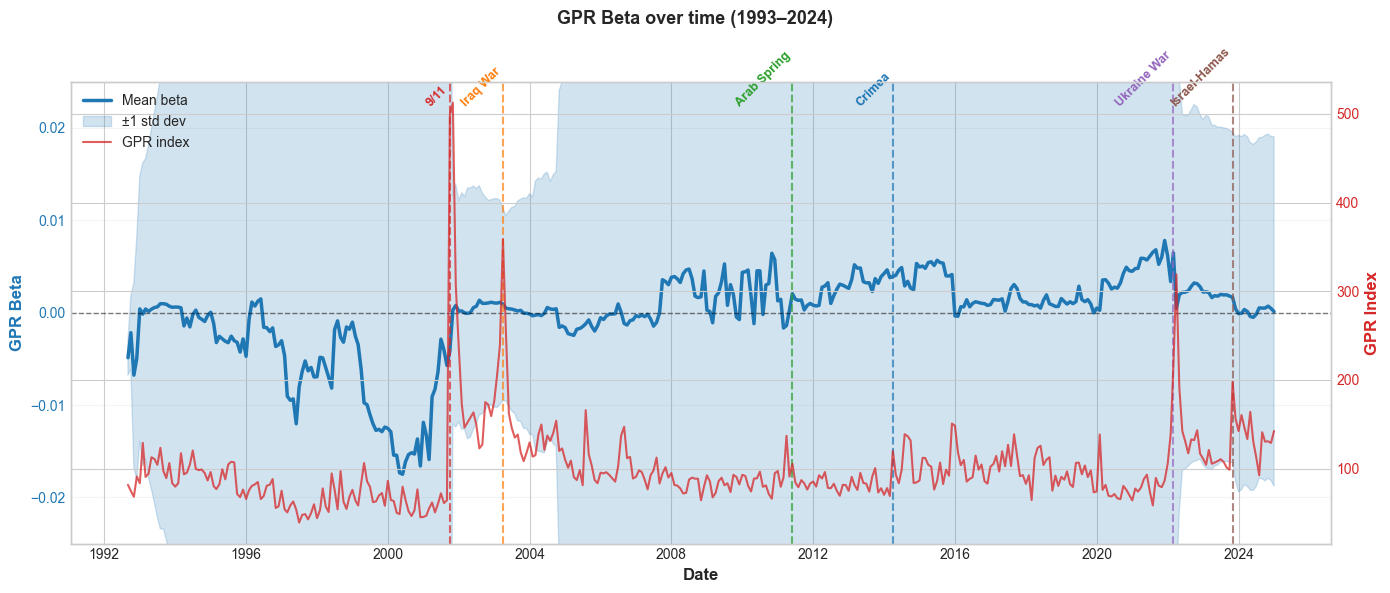


GPR BETA AT MAJOR EVENTS

9/11                 (2001-09-30)
  Beta: -0.004135 (spike: -0.003937 vs baseline -0.000198)
  GPR:  498.65 (spike: +398.30 vs baseline 100.34)

Iraq War             (2003-03-31)
  Beta: +0.000916 (spike: +0.001114 vs baseline -0.000198)
  GPR:  358.71 (spike: +258.37 vs baseline 100.34)

Arab Spring          (2011-05-31)
  Beta: +0.002056 (spike: +0.002254 vs baseline -0.000198)
  GPR:  105.34 (spike: +5.00 vs baseline 100.34)

Crimea               (2014-03-31)
  Beta: +0.003925 (spike: +0.004123 vs baseline -0.000198)
  GPR:  119.84 (spike: +19.49 vs baseline 100.34)

Ukraine War          (2022-02-28)
  Beta: +0.006474 (spike: +0.006671 vs baseline -0.000198)
  GPR:  216.16 (spike: +115.81 vs baseline 100.34)

Israel-Hamas         (2023-10-31)
  Beta: +0.001658 (spike: +0.001856 vs baseline -0.000198)
  GPR:  197.89 (spike: +97.54 vs baseline 100.34)

Full sample avg beta: -0.000198
Full sample avg GPR:  100.34

MONTHLY BETA DISPERSION ANALYSIS

FULL SAMPLE

In [64]:
# =============================================================================
# PLOT: GPR BETA WITH MAJOR EVENTS (POINT MARKERS) - FOCUSED VERSION
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


# Cross-sectional beta time series with 1 STD band
beta_ts = (df_analysis.dropna(subset=["date", "beta_final"])
           .groupby("date")["beta_final"]
           .agg(beta_mean="mean", beta_std=lambda x: x.std())
           .reset_index())

beta_ts["beta_p68_high"] = beta_ts["beta_mean"] + beta_ts["beta_std"]
beta_ts["beta_p68_low"] = beta_ts["beta_mean"] - beta_ts["beta_std"]

# GPR index
gpr_ts = df_gpr_merge[["date", "GPR"]].dropna().copy()
gpr_ts["date"] = pd.to_datetime(gpr_ts["date"])

plotdf = pd.merge(beta_ts, gpr_ts, on="date", how="inner").sort_values("date")

# --- Your event dates ---
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2011-05-31'): 'Arab Spring',
    pd.Timestamp('2014-03-31'): 'Crimea',
    pd.Timestamp('2022-02-28'): 'Ukraine War',
    pd.Timestamp('2023-10-31'): 'Israel-Hamas'
}

colors_event = {"9/11": "#d62728", "Iraq War": "#ff7f0e", "Arab Spring": "#2ca02c", 
                "Crimea": "#1f77b4", "Ukraine War": "#9467bd", "Israel-Hamas": "#8c564b"}

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Beta line + ±1 std band
ax1.plot(plotdf["date"], plotdf["beta_mean"], color="tab:blue", linewidth=2.5, label="Mean beta")
ax1.fill_between(plotdf["date"], plotdf["beta_p68_low"], plotdf["beta_p68_high"], 
                 color="tab:blue", alpha=0.2, label="±1 std dev")
ax1.axhline(0, color="black", linestyle="--", alpha=0.5, linewidth=1)
ax1.set_ylabel("GPR Beta", color="tab:blue", fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(-0.025, 0.025)
ax1.grid(True, alpha=0.2, axis="y")

# Event vertical lines with markers
for date, event_name in events.items():
    ax1.axvline(date, color=colors_event[event_name], linewidth=1.5, alpha=0.7, linestyle="--")
    
    # Find beta value at that date
    closest_idx = (plotdf["date"] - date).abs().idxmin()
    beta_at_event = plotdf.loc[closest_idx, "beta_mean"]
    
    # Add text label above the line
    ax1.text(date, 0.022, event_name, rotation=45, fontsize=9, 
             ha="right", va="bottom", color=colors_event[event_name], fontweight="bold")

# GPR index (right axis)
ax2 = ax1.twinx()
ax2.plot(plotdf["date"], plotdf["GPR"], color="tab:red", linewidth=1.5, label="GPR index", alpha=0.75)
ax2.set_ylabel("GPR Index", color="tab:red", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Format & legend
ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
ax1.xaxis.set_major_locator(mdates.YearLocator(4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labs1 + labs2, loc="upper left", fontsize=10)

fig.suptitle("GPR Beta over time (1993–2024)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("gpr_beta_events.png", dpi=300, bbox_inches="tight")
plt.show()

# Print stats
print(f"\n{'='*80}")
print("GPR BETA AT MAJOR EVENTS")
print(f"{'='*80}\n")

baseline_mean = plotdf["beta_mean"].mean()
baseline_gpr = plotdf["GPR"].mean()

for date, event_name in events.items():
    closest_idx = (plotdf["date"] - date).abs().idxmin()
    beta_event = plotdf.loc[closest_idx, "beta_mean"]
    gpr_event = plotdf.loc[closest_idx, "GPR"]
    
    spike = beta_event - baseline_mean
    gpr_spike = gpr_event - baseline_gpr
    
    print(f"{event_name:20s} ({date.date()})")
    print(f"  Beta: {beta_event:+.6f} (spike: {spike:+.6f} vs baseline {baseline_mean:.6f})")
    print(f"  GPR:  {gpr_event:.2f} (spike: {gpr_spike:+.2f} vs baseline {baseline_gpr:.2f})\n")

print(f"{'='*80}")
print(f"Full sample avg beta: {baseline_mean:.6f}")
print(f"Full sample avg GPR:  {baseline_gpr:.2f}")


# =============================================================================
# COMPUTE MONTHLY BETA DISPERSION (Standard Deviation)
# =============================================================================

import pandas as pd
import numpy as np

# Calculate monthly beta dispersion
beta_dispersion = df_analysis.groupby('date')['beta_final'].agg(['mean', 'std', 'count']).reset_index()
beta_dispersion.columns = ['date', 'mean_beta', 'std_beta', 'n_firms']

print("\n" + "="*80)
print("MONTHLY BETA DISPERSION ANALYSIS")
print("="*80 + "\n")

# Full sample stats
full_mean_disp = beta_dispersion['std_beta'].mean()
full_median_disp = beta_dispersion['std_beta'].median()

print(f"FULL SAMPLE (1993-2024)")
print(f"  Mean dispersion (std): {full_mean_disp:.6f}")
print(f"  Median dispersion: {full_median_disp:.6f}")
print(f"  Min: {beta_dispersion['std_beta'].min():.6f}")
print(f"  Max: {beta_dispersion['std_beta'].max():.6f}\n")

# 9/11 & Iraq War
period_911 = beta_dispersion[
    (beta_dispersion['date'] >= '2001-09-01') & 
    (beta_dispersion['date'] <= '2004-06-30')
]
mean_disp_911 = period_911['std_beta'].mean()
ratio_911 = (mean_disp_911 / full_mean_disp - 1) * 100

print(f"9/11 & IRAQ WAR (2001-09 to 2004-06)")
print(f"  Months: {len(period_911)}")
print(f"  Mean dispersion: {mean_disp_911:.6f}")
print(f"  Difference vs full sample: {ratio_911:.1f}%")
print(f"  Min: {period_911['std_beta'].min():.6f} | Max: {period_911['std_beta'].max():.6f}\n")

# Israel-Hamas & Recent
period_recent = beta_dispersion[
    (beta_dispersion['date'] >= '2023-10-01') & 
    (beta_dispersion['date'] <= '2024-12-31')
]
mean_disp_recent = period_recent['std_beta'].mean()
ratio_recent = (mean_disp_recent / full_mean_disp - 1) * 100

print(f"ISRAEL-HAMAS & RECENT (2023-10 to 2024-12)")
print(f"  Months: {len(period_recent)}")
print(f"  Mean dispersion: {mean_disp_recent:.6f}")
print(f"  Difference vs full sample: {ratio_recent:.1f}%")
print(f"  Min: {period_recent['std_beta'].min():.6f} | Max: {period_recent['std_beta'].max():.6f}\n")

print("="*80 + "\n")


In [65]:
#cell 6
# --- Step 2: Sort Firms and Construct Portfolios (The "Bulletproof" Version) ---

print("Sorting firms into deciles...")

# 1. CRITICAL FIX: Lag Market Cap
# We must weight Feb returns using Jan Market Cap to avoid look-ahead bias.
df_analysis = df_analysis.sort_values(['permno', 'date'])
df_analysis['mktcap_lag'] = df_analysis.groupby('permno')['mktcap'].shift(1)

# Drop the first month for each firm (since we don't have a lagged cap for it)
df_analysis = df_analysis.dropna(subset=['mktcap_lag'])

# 2. Keep only months with enough firms to form stable deciles
min_firms_per_month = 200  # you can raise this to 300 if you want stricter
month_counts = df_analysis.groupby('date')['permno'].transform('size')
df_analysis = df_analysis[month_counts >= min_firms_per_month].copy()

# 3. Sort into 10 Deciles based on LAGGED Beta (only on valid months now)
# NEW LINE (Uses the combined Hollstein beta)
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(
    lambda g: pd.qcut(g['beta_final'], 10, labels=False, duplicates='drop')
)


# 3. Robust Value-Weighted Mean Function
def vw_mean_robust(g):
    # Get weights (Lagged Cap) and Returns
    w = g['mktcap_lag']
    # r = g['ret_adj']
    r = g['excret']
    
    # Filter out any missing values or zero weights
    mask = w.notna() & r.notna() & (w > 0)
    w = w[mask]
    r = r[mask]
    
    # Safety: If no valid data, return NaN
    if len(w) == 0 or w.sum() == 0:
        return np.nan
        
    # Weighted Average
    return np.average(r, weights=w)

print("Calculating Value-Weighted Portfolio Returns...")

# 4. Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()

# Ensure we have columns for all 10 deciles (0..9). Missing ones become NaN.
port_rets = port_rets.reindex(columns=range(10))

# Keep only months where ALL 10 portfolios exist
port_rets = port_rets.dropna()

# Now rename safely
port_rets.columns = [f'P{i+1}' for i in range(10)]


# 6. Add Factors Back (for Step 3)
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)


counts = df_analysis.groupby(['date','decile']).size().unstack()
print("Any months missing a decile?", counts.isna().any(axis=1).sum())
print("Min firms per decile in any month:", counts.min().min())
print("Max firms per decile in any month:", counts.max().max())

avg_returns = port_rets[[f'P{i}' for i in range(1,11)]].mean()
print("Average portfolio excess returns (P1..P10):")
print(avg_returns)


# Additional checks:

P = port_rets[[f'P{i}' for i in range(1, 11)]]

# Correlation matrix (if two columns are identical, corr will be 1.0)
corr = P.corr()
display(corr)

eq_months = (port_rets['P9'] == port_rets['P10'])
print("Months where P9 == P10 exactly:", int(eq_months.sum()))

# Show those months if any
if eq_months.any():
    display(port_rets.loc[eq_months, ['P9','P10']].head(20))

diff = (port_rets['P10'] - port_rets['P9']).abs()
print(diff.describe())

print("Months where |P10-P9| < 1e-10:", int((diff < 1e-10).sum()))


print("Step 2 Complete! Portfolio Returns (Lagged VW) Ready.")
display(port_rets.head())

Sorting firms into deciles...


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/3060346687.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(


Calculating Value-Weighted Portfolio Returns...
Any months missing a decile? 0
Min firms per decile in any month: 26
Max firms per decile in any month: 516
Average portfolio excess returns (P1..P10):
P1     0.006648
P2     0.006552
P3     0.007710
P4     0.007505
P5     0.006849
P6     0.008898
P7     0.007515
P8     0.008321
P9     0.008123
P10    0.006224
dtype: float64


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/3060346687.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
P1,1.000000,0.874114,0.839082,0.783684,0.810097,0.789203,0.769177,0.763184,0.757152,0.774677
P2,0.874114,1.000000,0.886966,0.871659,0.858837,0.845365,0.839225,0.805139,0.787556,0.795843
P3,0.839082,0.886966,1.000000,0.903649,0.867609,0.866222,0.851971,0.812401,0.820194,0.806800
P4,0.783684,0.871659,0.903649,1.000000,0.891902,0.883967,0.873192,0.842746,0.816436,0.810698
P5,0.810097,0.858837,0.867609,0.891902,1.000000,0.896834,0.890728,0.861377,0.829733,0.815956
P6,0.789203,0.845365,0.866222,0.883967,0.896834,1.000000,0.885967,0.872824,0.850608,0.839149
P7,0.769177,0.839225,0.851971,0.873192,0.890728,0.885967,1.000000,0.879620,0.866107,0.828128
P8,0.763184,0.805139,0.812401,0.842746,0.861377,0.872824,0.879620,1.000000,0.844970,0.829286
P9,0.757152,0.787556,0.820194,0.816436,0.829733,0.850608,0.866107,0.844970,1.000000,0.855569
P10,0.774677,0.795843,0.806800,0.810698,0.815956,0.839149,0.828128,0.829286,0.855569,1.000000


Months where P9 == P10 exactly: 0
count    384.000000
mean       0.022438
std        0.020966
min        0.000068
25%        0.008403
50%        0.016067
75%        0.031091
max        0.158737
dtype: float64
Months where |P10-P9| < 1e-10: 0
Step 2 Complete! Portfolio Returns (Lagged VW) Ready.


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1993-01-31,0.021980,0.021393,-0.039882,0.009593,0.013574,-0.035885,0.010605,0.016230,0.024887,-0.003347,0.0093,0.0189,0.0590,0.0023,0.0485
1993-02-28,0.017973,0.015150,-0.002483,0.022175,0.008197,0.009183,0.002897,-0.014489,-0.019339,-0.013404,0.0012,-0.0339,0.0648,0.0022,0.0318
1993-03-31,0.008564,0.034362,0.038209,0.035120,0.007275,0.026656,0.014525,0.018921,0.018698,0.019233,0.0232,0.0029,0.0126,0.0025,0.0370
1993-04-30,-0.030237,-0.020093,-0.004027,-0.018691,-0.041889,-0.027620,-0.032783,-0.019104,-0.057382,-0.058051,-0.0305,-0.0062,0.0255,0.0024,0.0036
1993-05-31,0.034676,0.035188,0.027379,0.012176,0.011860,0.017928,0.042755,0.029660,0.062759,0.049276,0.0289,0.0206,-0.0346,0.0022,0.0021


STEP 3: Building a factor-mimicking GeoFactor (OOS, monthly) with EWMA weights...
TRUE in-sample correlation(GeoFactor_IS, shock): 0.1427
In-sample correlation(GeoFactor, shock): 0.1392
OOS correlation(GeoFactor, shock): 0.1392

GeoFactor ~ shock + factors (OOS):
                            OLS Regression Results                            
Dep. Variable:              GeoFactor   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.865
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.101
Time:                        17:41:18   Log-Likelihood:                 968.89
No. Observations:                 264   AIC:                            -1926.
Df Residuals:                     258   BIC:                            -1904.
Df Model:                           5                                         
Covariance Type:         

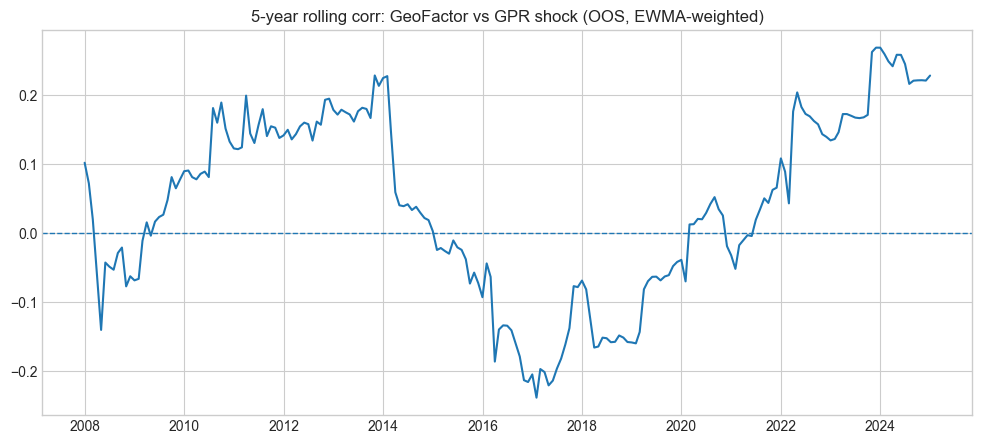


Shock ~ GeoFactor + factors (OOS):
                            OLS Regression Results                            
Dep. Variable:       gpr_news_shock_z   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.286
Date:                Fri, 23 Jan 2026   Prob (F-statistic):              0.270
Time:                        17:41:18   Log-Likelihood:                -240.58
No. Observations:                 264   AIC:                             493.2
Df Residuals:                     258   BIC:                             514.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [66]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("STEP 3: Building a factor-mimicking GeoFactor (OOS, monthly) with EWMA weights...")

shock_col   = "gpr_news_shock_z"
port_cols   = [f"P{i}" for i in range(1, 11)]
factor_cols = ["Mkt-RF", "SMB", "HML", "Mom"]

# ---------- EWMA weights helper ----------
def ewma_weights(T, half_life=24):
    """
    Returns length-T weights (oldest -> newest) where weight halves every 'half_life' months.
    Newest month gets weight 1.0, older months get smaller weights.
    """
    age = np.arange(T-1, -1, -1)  # oldest has biggest age
    w = 0.5 ** (age / half_life)
    return w

# ---------- Residualize y on factors using weighted regression ----------
def resid_on_factors_wls(y, X, w):
    Xc = sm.add_constant(X, has_constant="add")
    fit = sm.WLS(y, Xc, weights=w).fit()
    return fit.resid, fit.params

# ---------- OOS settings ----------
est_window = 120      # 10 years
half_life  = 24       # 2 years: weight halves every 24 months

# Merge shocks + portfolio returns + factors
df_check = df_gpr_merge[["date", shock_col]].merge(
    port_rets.reset_index()[["date"] + port_cols + factor_cols],
    on="date",
    how="inner"
).set_index("date").sort_index()

# ----- TRUE IN-SAMPLE (one-shot fit on full available sample) -----
df_full = df_check.dropna(subset=port_cols + factor_cols + [shock_col]).copy()

# Residualize portfolios on factors (full sample, EWMA weights)
w_full = ewma_weights(len(df_full), half_life=half_life)

E_full = []
for p in port_cols:
    resid_p, _ = resid_on_factors_wls(df_full[p], df_full[factor_cols], w_full)
    E_full.append(resid_p.values)
E_full = np.column_stack(E_full)

# Residualize shock on factors (full sample, EWMA weights)
X_shk_full = sm.add_constant(df_full[factor_cols], has_constant="add")
shock_resid_full = sm.WLS(df_full[shock_col].values, X_shk_full, weights=w_full).fit().resid

# Mimicking regression (full sample, EWMA weights)
X_full = sm.add_constant(E_full, has_constant="add")
fit_full = sm.WLS(shock_resid_full, X_full, weights=w_full).fit()
w_ins = fit_full.params[1:]
w_ins = w_ins / np.sum(np.abs(w_ins))

# In-sample GeoFactor series
df_full["GeoFactor_IS"] = E_full @ w_ins
corr_true_is = df_full["GeoFactor_IS"].corr(df_full[shock_col])
print(f"TRUE in-sample correlation(GeoFactor_IS, shock): {corr_true_is:.4f}")

# ---------- OOS construction ----------
geo = pd.Series(index=df_check.index, dtype=float)
weights_store = {}

dates = df_check.index.tolist()

for t in range(est_window, len(dates)):
    end_date   = dates[t]
    start_date = dates[t - est_window]

    window = df_check.loc[start_date:end_date].iloc[:-1]   # up to t-1 only
    today  = df_check.loc[[end_date]]                      # time t row

    # EWMA weights for this window (oldest->newest)
    w_win = ewma_weights(len(window), half_life=half_life)

    # 1) Residualize each portfolio on factors using WLS (EWMA)
    E_win = []
    E_t   = []

    for p in port_cols:
        resid_win, params = resid_on_factors_wls(window[p], window[factor_cols], w_win)

        # Predict factor piece at time t using the same params
        X_t = sm.add_constant(today[factor_cols], has_constant="add")
        pred_t = float(X_t.dot(params).iloc[0])

        # Residual at time t
        resid_t = float(today[p].iloc[0] - pred_t)

        E_win.append(resid_win.values)
        E_t.append(resid_t)

    E_win = np.column_stack(E_win)   # (T_window, 10)
    E_t   = np.array(E_t)            # (10,)

    # 2) Residualize the SHOCK on factors (EWMA) -> "factor-free shock"
    X_shk = sm.add_constant(window[factor_cols], has_constant="add")
    shock_resid = sm.WLS(window[shock_col].values, X_shk, weights=w_win).fit().resid

    # 3) Mimicking regression (EWMA): factor-free shock on residualized portfolios
    X = sm.add_constant(E_win, has_constant="add")
    fit_mimic = sm.WLS(shock_resid, X, weights=w_win).fit()

    w = fit_mimic.params[1:]  # 10 weights

    # Normalize weights to avoid leverage exploding
    w = w / np.sum(np.abs(w))
    weights_store[end_date] = w

    # GeoFactor_t = w' * residualized portfolio returns at time t
    geo.loc[end_date] = float(E_t @ w)

df_check["GeoFactor"] = geo

# In-sample correlation (uses all non-missing GeoFactor months)
df_is = df_check.dropna(subset=["GeoFactor"]).copy()
corr_is = df_is["GeoFactor"].corr(df_is[shock_col])
print(f"In-sample correlation(GeoFactor, shock): {corr_is:.4f}")

# OOS sample (same as before)
df_oos = df_is.copy()

# ---------- Evaluate ----------
corr_oos = df_oos["GeoFactor"].corr(df_oos[shock_col])
print(f"OOS correlation(GeoFactor, shock): {corr_oos:.4f}")

X = sm.add_constant(df_oos[[shock_col] + factor_cols], has_constant="add")
y = df_oos["GeoFactor"]
reg = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
print("\nGeoFactor ~ shock + factors (OOS):")
print(reg.summary())

# Rolling correlation plot
df_oos["rollcorr_60"] = df_oos["GeoFactor"].rolling(60).corr(df_oos[shock_col])
plt.figure(figsize=(12, 5))
plt.plot(df_oos.index, df_oos["rollcorr_60"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("5-year rolling corr: GeoFactor vs GPR shock (OOS, EWMA-weighted)")
plt.show()

# Optional: flip sign so GeoFactor is positively correlated with shocks
#if corr_oos < 0:
  #  df_oos["GeoFactor"] *= -1
    #corr_flip = df_oos["GeoFactor"].corr(df_oos[shock_col])
    #print(f"\nFlipped sign. New OOS correlation: {corr_flip:.4f}")

# Extra diagnostic: does the shock get explained by GeoFactor?
X2 = sm.add_constant(df_oos[["GeoFactor"] + factor_cols], has_constant="add")
y2 = df_oos[shock_col]
reg2 = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
print("\nShock ~ GeoFactor + factors (OOS):")
print(reg2.summary())

print("\nCorrelations with factors (OOS):")
print(df_oos[["GeoFactor"] + factor_cols].corr()["GeoFactor"])

STEP 4: Empirical Validation - Event Studies & Benchmarking

Top 5 Geopolitical Shock Months (OOS):


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' d

,date,gpr_news_shock_z,GeoFactor,Guns,Oil,Mkt-RF
230,2022-03-31,3.925180,0.011741,0.0127,0.0974,0.0308
2,2003-03-31,3.396497,0.004230,0.0449,0.0154,0.0109
249,2023-10-31,2.873518,0.016802,0.0936,-0.0617,-0.0315
229,2022-02-28,2.615820,-0.002952,0.1050,0.0824,-0.0228
30,2005-07-31,1.761605,-0.001895,-0.0219,0.0554,0.0392


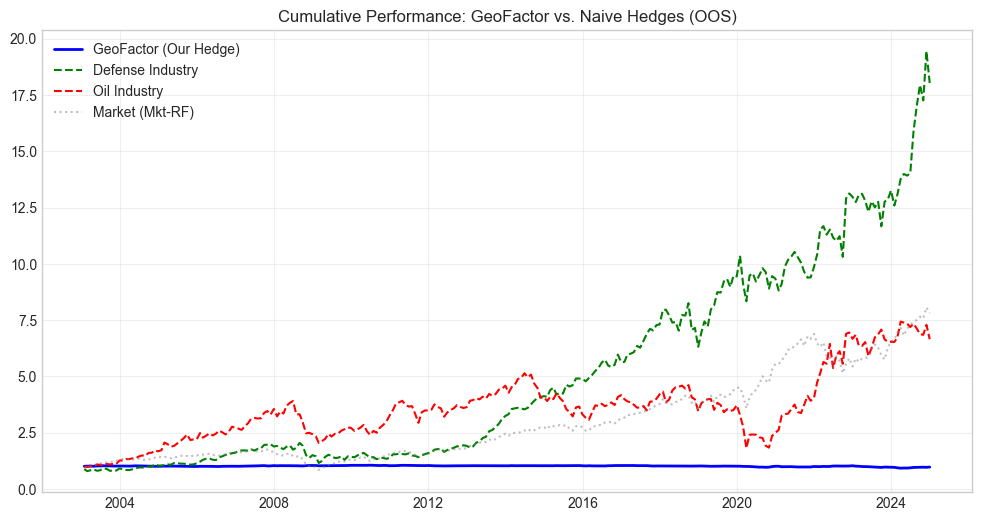


Average Returns during High Stress Months (N=17):
GeoFactor    0.002637
Guns         0.018729
Oil          0.012129
Mkt-RF      -0.008153
dtype: float64

Hit Ratio (Win Rate) during High Stress Months:
GeoFactor    0.529412
Guns         0.705882
Oil          0.588235
Mkt-RF       0.470588
dtype: float64


In [67]:
#cell 8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web

print("STEP 4: Empirical Validation - Event Studies & Benchmarking")

# --- 1. Get Benchmark Data (Oil & Defense) ---
# We use Fama-French Industry portfolios.
# Note: FF data often comes with trailing spaces in names.
ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
ind49 = ind49.reset_index().rename(columns={'Date': 'date'})
ind49['date'] = ind49['date'].dt.to_timestamp(freq='M') + pd.offsets.MonthEnd(0)

# CRITICAL FIX: Strip hidden spaces from column names (e.g., "Guns " -> "Guns")
ind49.columns = ind49.columns.str.strip()

# Now we can safely access "Guns" and "Oil"
benchmarks = ind49[['date', 'Guns', 'Oil']].copy()
benchmarks[['Guns', 'Oil']] = benchmarks[['Guns', 'Oil']] / 100.0 # Convert to decimals

# Merge with our GeoFactor and GPR
df_val = df_oos.merge(benchmarks, on='date', how='inner').copy()

# --- 2. Event Study: Performance during High GPR Spikes ---
# Identify top 5 geopolitical shock months in the OOS period
top_shocks = df_val.nlargest(5, 'gpr_news_shock_z')

print("\nTop 5 Geopolitical Shock Months (OOS):")
display(top_shocks[['date', 'gpr_news_shock_z', 'GeoFactor', 'Guns', 'Oil', 'Mkt-RF']])

# --- 3. Cumulative Return Comparison (Log Returns) ---
df_val['cum_geo'] = (1 + df_val['GeoFactor']).cumprod()
df_val['cum_guns'] = (1 + df_val['Guns']).cumprod()
df_val['cum_oil'] = (1 + df_val['Oil']).cumprod()
df_val['cum_mkt'] = (1 + df_val['Mkt-RF']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_val['date'], df_val['cum_geo'], label='GeoFactor (Our Hedge)', linewidth=2, color='blue')
plt.plot(df_val['date'], df_val['cum_guns'], label='Defense Industry', linestyle='--', color='green')
plt.plot(df_val['date'], df_val['cum_oil'], label='Oil Industry', linestyle='--', color='red')
plt.plot(df_val['date'], df_val['cum_mkt'], label='Market (Mkt-RF)', linestyle=':', color='gray', alpha=0.5)

plt.title("Cumulative Performance: GeoFactor vs. Naive Hedges (OOS)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 4. Hedging Efficiency Test ---
# We want to see if our GeoFactor offers "Alpha" during high GPR times compared to benchmarks.

# Define "High Stress" as months where the shock is > 1 Standard Deviation
high_risk_months = df_val[df_val['gpr_news_shock_z'] > 1.0] 

print(f"\nAverage Returns during High Stress Months (N={len(high_risk_months)}):")
print(high_risk_months[['GeoFactor', 'Guns', 'Oil', 'Mkt-RF']].mean())

print("\nHit Ratio (Win Rate) during High Stress Months:")
print((high_risk_months[['GeoFactor', 'Guns', 'Oil', 'Mkt-RF']] > 0).mean())

In [68]:
# =============================================================================
# FAMA–MacBETH: GPR ALPHA & PRICING TEST
# =============================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm


# Prep: sort, lag market cap, log size
df_analysis = df_analysis.sort_values(["permno", "date"]).copy()
df_analysis["mktcap_lag"] = df_analysis.groupby("permno")["mktcap"].shift(1)
df_analysis["log_size"] = np.log(df_analysis["mktcap_lag"])


# Use lagged beta in regression
fm = df_analysis[['date', 'permno', 'excret', 'beta_final']].dropna()


# Monthly cross-sectional regressions
rows = []
for dt, g in fm.groupby("date"):
    if len(g) < 200:
        continue

    y = g["excret"].values
    X = sm.add_constant(g[["beta_final"]].values)
    res = sm.OLS(y, X).fit()
    
    rows.append({
        "date": dt,
        "alpha_t": res.params[0],
        "lambda_gpr_t": res.params[1],
        "n_firms": len(g),
        "r2": res.rsquared,
    })

df_fm = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

# HAC inference on average risk prices
def hac_mean_tstat(series, maxlags=12):
    s = series.dropna().values
    fit = sm.OLS(s, np.ones((len(s), 1))).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    return float(fit.params[0]), float(fit.tvalues[0]), float(fit.pvalues[0])

alpha_mean, alpha_t, alpha_p = hac_mean_tstat(df_fm["alpha_t"], maxlags=6)
lambda_mean, lambda_t, lambda_p = hac_mean_tstat(df_fm["lambda_gpr_t"], maxlags=6)

print(f"\n{'='*80}")
print(f"Fama–MacBeth: {len(df_fm)} monthly cross-sections")
print(f"Period: {df_fm['date'].min().date()} to {df_fm['date'].max().date()}")
print(f"{'='*80}")

print("\n--- ALPHA TEST ---")
print(f"Monthly alpha: {alpha_mean:.6f} | t-stat={alpha_t:.3f} | p-value={alpha_p:.4f}")
print(f"Annualized: {12*alpha_mean:.6f}")
print(f"Significant? {abs(alpha_t) > 1.96}")

print("\n--- PRICING TEST ---")
print(f"Monthly lambda_GPR: {lambda_mean:.6f} | t-stat={lambda_t:.3f} | p-value={lambda_p:.4f}")
print(f"Annualized: {12*lambda_mean:.6f}")
print(f"Significant? {abs(lambda_t) > 1.96}")




Fama–MacBeth: 384 monthly cross-sections
Period: 1993-01-31 to 2024-12-31

--- ALPHA TEST ---
Monthly alpha: 0.009304 | t-stat=3.074 | p-value=0.0021
Annualized: 0.111647
Significant? True

--- PRICING TEST ---
Monthly lambda_GPR: -0.015442 | t-stat=-0.896 | p-value=0.3705
Annualized: -0.185308
Significant? False


In [69]:
# =============================================================================
# SUBSAMPLE FAMA-MACBETH: 2 Crisis Regimes (Low Beta Dispersion)
# =============================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Define periods
periods = {
    'Full Sample (1993-2024)': ('1993-02-28', '2024-12-31'),
    '9/11 & Iraq War (2001-09 to 2004-06)': ('2001-09-01', '2004-06-30'),
    'Ukraine & Recent Crisis (2022-06 to 2024-12)': ('2022-06-01', '2024-12-31'),
}

def run_fm_subsample(df_analysis, start_date, end_date, period_name):
    """Run FM regression for a subsample period"""
    
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    df_sub = df_analysis[(df_analysis['date'] >= start) & (df_analysis['date'] <= end)].copy()
    fm = df_sub[['date', 'permno', 'excret', 'beta_final']].dropna()
    
    rows = []
    for dt, g in fm.groupby("date"):
        if len(g) < 200:
            continue
        y = g["excret"].values
        X = sm.add_constant(g[["beta_final"]].values)
        res = sm.OLS(y, X).fit()
        rows.append({
            "date": dt,
            "alpha_t": res.params[0],
            "lambda_gpr_t": res.params[1],
            "n_firms": len(g),
        })
    
    df_fm = pd.DataFrame(rows)
    
    if len(df_fm) == 0:
        return None
    
    # HAC inference
    alpha_mean, alpha_t, alpha_p = hac_mean_tstat(df_fm["alpha_t"], maxlags=6)
    lambda_mean, lambda_t, lambda_p = hac_mean_tstat(df_fm["lambda_gpr_t"], maxlags=6)
    
    return {
        'period': period_name,
        'n_months': len(df_fm),
        'alpha_monthly': alpha_mean,
        'alpha_annual': 12 * alpha_mean,
        'alpha_t': alpha_t,
        'alpha_p': alpha_p,
        'lambda_monthly': lambda_mean,
        'lambda_annual': 12 * lambda_mean,
        'lambda_t': lambda_t,
        'lambda_p': lambda_p,
    }

# Run all periods
results_list = []
for period_name, (start_date, end_date) in periods.items():
    res = run_fm_subsample(df_analysis, start_date, end_date, period_name)
    if res is not None:
        results_list.append(res)

results_df = pd.DataFrame(results_list)

# Print results
print("\n" + "="*100)
print("FAMA-MACBETH: LOW BETA DISPERSION CRISIS REGIMES")
print("="*100 + "\n")

for idx, row in results_df.iterrows():
    print(f"{row['period']}")
    print(f"  N Months: {int(row['n_months'])}")
    print(f"  Alpha:  {100*row['alpha_monthly']:.4f}% monthly | {100*row['alpha_annual']:.2f}% annual | t={row['alpha_t']:.3f} | p={row['alpha_p']:.4f}")
    print(f"  Lambda: {100*row['lambda_monthly']:.4f}% monthly | {100*row['lambda_annual']:.2f}% annual | t={row['lambda_t']:.3f} | p={row['lambda_p']:.4f}")
    print()

print("="*100 + "\n")




FAMA-MACBETH: LOW BETA DISPERSION CRISIS REGIMES

Full Sample (1993-2024)
  N Months: 383
  Alpha:  0.9248% monthly | 11.10% annual | t=3.048 | p=0.0023
  Lambda: -1.3082% monthly | -15.70% annual | t=-0.769 | p=0.4418

9/11 & Iraq War (2001-09 to 2004-06)
  N Months: 34
  Alpha:  1.9443% monthly | 23.33% annual | t=1.544 | p=0.1225
  Lambda: -2.3378% monthly | -28.05% annual | t=-0.154 | p=0.8773

Ukraine & Recent Crisis (2022-06 to 2024-12)
  N Months: 31
  Alpha:  0.4242% monthly | 5.09% annual | t=0.765 | p=0.4444
  Lambda: -14.5606% monthly | -174.73% annual | t=-2.139 | p=0.0324




In [87]:
# =============================================================================
# HYPOTHESIS 3: GPR Sensitivity Across Industries & Firm Size
# =============================================================================

import numpy as np
import pandas as pd
from scipy import stats

print("\n" + "="*100)
print("H3: GEOPOLITICAL RISK SENSITIVITY ACROSS INDUSTRIES AND FIRM SIZE")
print("="*100 + "\n")

# Prepare SIC codes
df_analysis['siccd'] = pd.to_numeric(df_analysis['siccd'], errors='coerce')
df_analysis['sic2'] = (df_analysis['siccd'] // 100).astype('Int64')

# =============================================================================
# DEFINE GPR-FOCUSED INDUSTRY CLASSIFICATION
# =============================================================================

def classify_industry_gpr(sic2):
    """Classification emphasizing GPR-sensitive sectors for geopolitical risk"""
    if pd.isna(sic2):
        return 'Unknown'
    
    # ========== HIGHLY GPR-SENSITIVE ==========
    
    # Energy & Oil (MOST exposed to geopolitical shocks)
    if sic2 in [13, 29]:  # Oil/Gas extraction, Petroleum refining
        return 'Energy'
    
    # Defense & Aerospace (directly exposed)
    if sic2 == 3721:  # Aircraft manufacturing (more specific than 37)
        return 'Defense/Aerospace'
    # Broader: 37 includes all transportation equip
    if sic2 == 37:
        return 'Manufacturing'  # Too broad, reclassify
    
    # Semiconductors & Chips (Taiwan exposure, supply chain risk)
    if sic2 == 36:  # Electronic & electrical equipment
        return 'Semiconductors'
    
    # ========== MODERATE GPR SENSITIVITY ==========
    
    # Mining & Materials (commodity/geopolitical exposure)
    if 10 <= sic2 <= 14:
        return 'Mining & Materials'
    
    # Transportation Equipment (supply chains)
    if sic2 in [37]:  # Cars, defense contractors mixed
        return 'Transportation Equipment'
    
    # Technology (supply chain, intellectual property)
    if sic2 in [73, 87]:  # Business services, Software
        return 'Technology/Services'
    
    # ========== LOWER GPR SENSITIVITY ==========
    
    # Utilities (defensive, geopolitical insulation)
    if sic2 == 49:
        return 'Utilities'
    
    # Finance (macro exposure, not direct GPR)
    if 60 <= sic2 <= 67:
        return 'Finance'
    
    # Consumer Staples (defensive)
    if sic2 in [20, 21]:  # Food, Tobacco
        return 'Consumer Staples'
    
    # Consumer Cyclical (demand-sensitive but not GPR-specific)
    if sic2 in [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]:
        return 'Retail & Wholesale'
    
    # Construction & Real Estate
    if sic2 in [15, 16, 17]:
        return 'Construction'
    
    # Transportation (exposure if international)
    if sic2 in [40, 41, 42, 44, 45, 47]:
        return 'Transportation'
    
    # Manufacturing - Other
    if sic2 in [22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 38, 39]:
        return 'Manufacturing'
    
    # Healthcare (relatively insulated)
    if sic2 in [80, 81, 82]:
        return 'Healthcare'
    
    # Services & Other
    if sic2 in [70, 72, 75, 76, 78, 79, 83, 84, 86, 87, 89]:
        return 'Services'
    
    # Agriculture
    if sic2 in [1, 2, 7, 8, 9]:
        return 'Agriculture'
    
    return 'Other'


df_analysis['industry'] = df_analysis['sic2'].apply(classify_industry)
df_analysis['log_mktcap'] = np.log(df_analysis['mktcap_lag'])

# =============================================================================
# SECTION 1: GPR BETA BY INDUSTRY
# =============================================================================

print("SECTION 1: AVERAGE GPR BETA BY INDUSTRY")
print("-" * 100 + "\n")

industry_stats = df_analysis.groupby('industry')['beta_final'].agg([
    ('Mean Beta', 'mean'),
    ('Std Dev', 'std'),
    ('N Firms', 'count')
]).round(6).sort_values('Mean Beta', ascending=False)

print(industry_stats.to_string())
print()

# ANOVA test
industries = df_analysis['industry'].unique()
groups = [df_analysis[df_analysis['industry'] == ind]['beta_final'].dropna().values 
          for ind in industries]
f_stat, p_val = stats.f_oneway(*groups)

print(f"\nANOVA Test: F = {f_stat:.2f}, p < {p_val:.4f}")
print(f"Result: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'} industry variation\n")

# Highlight key sectors
print("🔥 KEY GPR-SENSITIVE SECTORS:")
print("-" * 100)
key_sectors = ['Energy', 'Defense/Aerospace', 'Utilities', 'Consumer Staples', 'Technology']
for sector in key_sectors:
    if sector in industry_stats.index:
        row = industry_stats.loc[sector]
        print(f"  {sector:20s}: Beta = {row['Mean Beta']:+.6f}  (N = {int(row['N Firms']):,})")

# =============================================================================
# SECTION 2: GPR BETA BY FIRM SIZE
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 2: GPR BETA BY FIRM SIZE (QUINTILES)")
print("-" * 100 + "\n")

df_analysis['size_quintile'] = df_analysis.groupby('date')['mktcap_lag'].transform(
    lambda x: pd.qcut(x, q=5, labels=['Q1 (Small)', 'Q2', 'Q3', 'Q4', 'Q5 (Large)'], 
                      duplicates='drop')
)

size_stats = df_analysis.groupby('size_quintile', observed=True)['beta_final'].agg([
    ('Mean Beta', 'mean'),
    ('Std Dev', 'std'),
    ('N Firms', 'count')
]).round(6)

print(size_stats.to_string())
print()

# ANOVA for size
size_groups = [df_analysis[df_analysis['size_quintile'] == q]['beta_final'].dropna().values 
               for q in ['Q1 (Small)', 'Q2', 'Q3', 'Q4', 'Q5 (Large)']]
f_stat_size, p_val_size = stats.f_oneway(*size_groups)

print(f"\nANOVA Test: F = {f_stat_size:.2f}, p < {p_val_size:.4f}")
print(f"Result: {'✓ Significant' if p_val_size < 0.05 else '✗ Not significant'} size effect\n")

# Calculate spread
large_beta = size_stats.loc['Q5 (Large)', 'Mean Beta']
small_beta = size_stats.loc['Q1 (Small)', 'Mean Beta']
spread = large_beta - small_beta

print(f"Size Premium: Large - Small = {spread:+.6f}")
print(f"→ {'Large firms are better GPR hedges' if spread > 0 else 'Small firms are better GPR hedges'}")

# =============================================================================
# SECTION 3: INTERACTION - SIZE WITHIN KEY INDUSTRIES
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 3: SIZE EFFECT WITHIN KEY INDUSTRIES")
print("-" * 100 + "\n")

key_industries = ['Energy', 'Finance', 'Technology', 'Manufacturing']

for ind in key_industries:
    df_ind = df_analysis[df_analysis['industry'] == ind].copy()
    if len(df_ind) < 1000:
        continue
    
    # Create size groups within industry
    df_ind['size_group'] = pd.qcut(df_ind['mktcap_lag'], q=3, 
                                     labels=['Small', 'Medium', 'Large'], 
                                     duplicates='drop')
    
    size_ind = df_ind.groupby('size_group', observed=True)['beta_final'].mean()
    
    print(f"{ind}:")
    for size in ['Small', 'Medium', 'Large']:
        if size in size_ind.index:
            print(f"  {size:10s}: {size_ind[size]:+.6f}")
    print()

# =============================================================================
# SUMMARY
# =============================================================================

print("="*100)
print("H3 SUMMARY")
print("="*100 + "\n")

print("1. INDUSTRY HETEROGENEITY:")
print(f"   Top 3 Industries: {', '.join(industry_stats.index[:3])}")
print(f"   Bottom 3 Industries: {', '.join(industry_stats.index[-3:])}")
print(f"   Range: {industry_stats.iloc[0, 0]:.4f} to {industry_stats.iloc[-1, 0]:.4f}")
print(f"   Statistical Significance: F = {f_stat:.2f}, p < {p_val:.4f}\n")

print("2. SIZE EFFECT:")
print(f"   Large Firms (Q5): {large_beta:+.6f}")
print(f"   Small Firms (Q1): {small_beta:+.6f}")
print(f"   Spread (L-S): {spread:+.6f}")
print(f"   Statistical Significance: F = {f_stat_size:.2f}, p < {p_val_size:.4f}\n")

print("3. INTERPRETATION:")
if spread > 0:
    print("   → Large firms provide better hedging against geopolitical risk")
    print("   → Driven by diversification and financial flexibility")
else:
    print("   → Small firms are more sensitive to geopolitical shocks")
    print("   → Higher operational and financial leverage")

print("\n" + "="*100)



H3: GEOPOLITICAL RISK SENSITIVITY ACROSS INDUSTRIES AND FIRM SIZE

SECTION 1: AVERAGE GPR BETA BY INDUSTRY
----------------------------------------------------------------------------------------------------

                    Mean Beta   Std Dev  N Firms
industry                                        
Energy               0.007997  0.056268    50517
Mining & Materials   0.006948  0.060772    13123
Other                0.004163  0.036956    74801
Defense/Aerospace    0.001609  0.041395    28050
Unknown              0.001059  0.005133       22
Healthcare           0.000007  0.054595    25596
Utilities           -0.000018  0.033486    48541
Transportation      -0.000131  0.048441    66902
Manufacturing       -0.000666  0.050884   308790
Finance             -0.000806  0.037968   282071
Services            -0.000978  0.051638    73881
Agriculture         -0.001356  0.041445     3549
Consumer Staples    -0.001399  0.039613    31370
Construction        -0.001953  0.051372    16586
Techno

In [71]:
# =============================================================================
# SECTION 1B: STATISTICAL SIGNIFICANCE OF INDUSTRY BETAS
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 1B: STATISTICAL SIGNIFICANCE TESTS FOR KEY INDUSTRIES")
print("-" * 100 + "\n")

# Test if each industry's mean beta is significantly different from zero
from scipy import stats

key_industries = ['Energy', 'Defense/Aerospace', 'Technology', 'Consumer Cyclical', 
                  'Finance', 'Utilities', 'Consumer Staples']

sig_results = []

for industry in key_industries:
    if industry not in df_analysis['industry'].values:
        continue
    
    # Get all betas for this industry
    betas = df_analysis[df_analysis['industry'] == industry]['beta_final'].dropna()
    
    if len(betas) < 30:
        continue
    
    # One-sample t-test: H0: mean beta = 0
    t_stat, p_val = stats.ttest_1samp(betas, 0)
    mean_beta = betas.mean()
    
    sig_results.append({
        'Industry': industry,
        'Mean Beta': mean_beta,
        'T-Stat': t_stat,
        'P-Value': p_val,
        'Significant?': '✓' if p_val < 0.05 else '✗',
        'N': len(betas)
    })

sig_df = pd.DataFrame(sig_results)
print(sig_df.to_string(index=False))

print("\n" + "-" * 100)
print("INTERPRETATION:")
print("✓ = Significantly different from zero at 5% level")
print("✗ = Not significantly different from zero")
print("-" * 100 + "\n")

# =============================================================================
# SECTION 1C: PAIRWISE COMPARISONS (Energy vs Others)
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 1C: PAIRWISE COMPARISONS - ENERGY VS KEY SECTORS")
print("-" * 100 + "\n")

energy_betas = df_analysis[df_analysis['industry'] == 'Energy']['beta_final'].dropna()

comparisons = ['Technology', 'Consumer Cyclical', 'Finance', 'Defense/Aerospace']

for comp_ind in comparisons:
    comp_betas = df_analysis[df_analysis['industry'] == comp_ind]['beta_final'].dropna()
    
    if len(comp_betas) < 30:
        continue
    
    # Two-sample t-test: H0: Energy beta = Comparison beta
    t_stat, p_val = stats.ttest_ind(energy_betas, comp_betas, equal_var=False)
    
    diff = energy_betas.mean() - comp_betas.mean()
    
    print(f"Energy vs {comp_ind}:")
    print(f"  Difference: {diff:+.6f}")
    print(f"  T-Stat: {t_stat:.3f}")
    print(f"  P-Value: {p_val:.4f}")
    print(f"  Result: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'}\n")

# =============================================================================
# SECTION 2B: SIZE QUINTILE SIGNIFICANCE
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 2B: SIZE QUINTILE PAIRWISE TESTS")
print("-" * 100 + "\n")

# Test Q5 (Large) vs Q1 (Small)
q5_betas = df_analysis[df_analysis['size_quintile'] == 'Q5 (Large)']['beta_final'].dropna()
q1_betas = df_analysis[df_analysis['size_quintile'] == 'Q1 (Small)']['beta_final'].dropna()

t_stat, p_val = stats.ttest_ind(q5_betas, q1_betas, equal_var=False)
diff = q5_betas.mean() - q1_betas.mean()

print("Large (Q5) vs Small (Q1):")
print(f"  Q5 Mean: {q5_betas.mean():+.6f}")
print(f"  Q1 Mean: {q1_betas.mean():+.6f}")
print(f"  Difference (L-S): {diff:+.6f}")
print(f"  T-Stat: {t_stat:.3f}")
print(f"  P-Value: {p_val:.6f}")
print(f"  Result: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'}\n")

# Test monotonicity: Q1 < Q2 < Q3 < Q4 < Q5
print("Monotonicity Test (Adjacent Quintiles):")
quintiles = ['Q1 (Small)', 'Q2', 'Q3', 'Q4', 'Q5 (Large)']
for i in range(len(quintiles)-1):
    q_low = df_analysis[df_analysis['size_quintile'] == quintiles[i]]['beta_final'].dropna()
    q_high = df_analysis[df_analysis['size_quintile'] == quintiles[i+1]]['beta_final'].dropna()
    
    t_stat, p_val = stats.ttest_ind(q_high, q_low, equal_var=False)
    diff = q_high.mean() - q_low.mean()
    
    print(f"  {quintiles[i+1]} vs {quintiles[i]}: Δ={diff:+.6f}, t={t_stat:.2f}, p={p_val:.4f}")

# =============================================================================
# SECTION 3B: SIZE WITHIN ENERGY (Most important!)
# =============================================================================

print("\n" + "-" * 100)
print("SECTION 3B: SIZE EFFECT WITHIN ENERGY SECTOR")
print("-" * 100 + "\n")

df_energy = df_analysis[df_analysis['industry'] == 'Energy'].copy()

if len(df_energy) > 1000:
    df_energy['size_tercile'] = pd.qcut(df_energy['mktcap_lag'], q=3, 
                                         labels=['Small', 'Medium', 'Large'], 
                                         duplicates='drop')
    
    tercile_stats = df_energy.groupby('size_tercile', observed=True)['beta_final'].agg([
        ('Mean Beta', 'mean'),
        ('Std Dev', 'std'),
        ('N', 'count')
    ]).round(6)
    
    print("Energy Sector - Size Terciles:")
    print(tercile_stats.to_string())
    print()
    
    # Test Large vs Small within Energy
    energy_large = df_energy[df_energy['size_tercile'] == 'Large']['beta_final'].dropna()
    energy_small = df_energy[df_energy['size_tercile'] == 'Small']['beta_final'].dropna()
    
    t_stat, p_val = stats.ttest_ind(energy_large, energy_small, equal_var=False)
    diff = energy_large.mean() - energy_small.mean()
    
    print(f"\nLarge vs Small Energy Firms:")
    print(f"  Difference: {diff:+.6f}")
    print(f"  T-Stat: {t_stat:.3f}")
    print(f"  P-Value: {p_val:.6f}")
    print(f"  Result: {'✓ Significant' if p_val < 0.05 else '✗ Not significant'}")
    print(f"  → Size effect is {'present' if p_val < 0.05 else 'absent'} within Energy sector")

print("\n" + "="*100 + "\n")



----------------------------------------------------------------------------------------------------
SECTION 1B: STATISTICAL SIGNIFICANCE TESTS FOR KEY INDUSTRIES
----------------------------------------------------------------------------------------------------

         Industry  Mean Beta     T-Stat       P-Value Significant?      N
           Energy   0.007997  31.942566 1.117019e-221            ✓  50517
Defense/Aerospace   0.001609   6.510239  7.629801e-11            ✓  28050
       Technology  -0.002105 -22.071052 7.297682e-108            ✓ 303383
Consumer Cyclical  -0.004907 -37.804595  0.000000e+00            ✓ 140432
          Finance  -0.000806 -11.274458  1.780263e-29            ✓ 282071
        Utilities  -0.000018  -0.121380  9.033905e-01            ✗  48541
 Consumer Staples  -0.001399  -6.255482  4.014000e-10            ✓  31370

----------------------------------------------------------------------------------------------------
INTERPRETATION:
✓ = Significantly differ

In [72]:
#cell 9
import pandas as pd

print("--- DATA SANITY CHECK ---")

# 1. Create a copy of the columns we care about from our CLEANED dataframe
# We use 'df_stocks_clean' because it has the rawest form of valid data
# Note: We use lowercase names because we converted them in Cell 4
df_investigation = df_stocks_clean[['ret', 'prc', 'shrout', 'ret_adj', 'mktcap']].copy()

# 2. Handle Negative Prices (standard CRSP convention for bid/ask averages)
df_investigation['prc_abs'] = df_investigation['prc'].abs()

# 3. Calculate Market Cap in MILLIONS for easier reading
# CRSP 'shrout' is in thousands. PRC * SHROUT = Value in Thousands.
# Divide by 1000 to get Millions.
df_investigation['mktcap_mil'] = df_investigation['mktcap'] / 1000.0

# 4. Print Statistics
# We look at 'ret_adj' (what we actually use) and 'mktcap_mil'
stats = df_investigation[['ret', 'ret_adj', 'mktcap_mil', 'prc_abs']].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

print("\nSummary Statistics (Cleaned Data):")
# Transpose for easier reading: showing count, mean, min, median, max
display(stats.T[['count', 'mean', 'std', 'min', '1%', '50%', '99%', 'max']])

# 5. Check for Suspicious Max Returns
# If 'ret_adj' max is 50.0 (5000%), that might be an error.
print("\nTop 5 Highest Returns (Check for Data Errors):")
display(df_investigation.nlargest(5, 'ret_adj'))

# 6. Check for Unit Errors in Market Cap
# The Max Market Cap should be consistent with Apple/Microsoft/Exxon (e.g., 2,000,000+ Millions in recent years)
print("\nTop 5 Largest Companies (Check for Unit Errors):")
display(df_investigation.nlargest(5, 'mktcap_mil'))

--- DATA SANITY CHECK ---

Summary Statistics (Cleaned Data):


,count,mean,std,min,1%,50%,99%,max
ret,2431293.0,0.010785,0.200055,-0.995690,-0.425122,0.000,0.619048,2.658383e+01
ret_adj,2431295.0,0.007898,0.163943,-0.721491,-0.393939,0.000,0.542681,2.174686e+00
mktcap_mil,2431295.0,3138.126610,27291.940671,0.010563,1.588875,155.325,54171.266250,3.785304e+06
prc_abs,2431295.0,50.927886,2917.376747,0.010500,0.218750,12.710,172.000000,7.240400e+05



Top 5 Highest Returns (Check for Data Errors):


,ret,prc,shrout,ret_adj,mktcap,prc_abs,mktcap_mil
15073,3.272727,1.46875,56991.0,2.174686,83705.53125,1.46875,83.705531
28301,3.500000,0.56250,48217.0,2.174686,27122.06250,0.56250,27.122062
92273,2.692308,1.50000,5346.0,2.174686,8019.00000,1.50000,8.019000
162397,2.250000,1.62500,9046.0,2.174686,14699.75000,1.62500,14.699750
226350,4.428571,1.18750,8155.0,2.174686,9684.06250,1.18750,9.684062



Top 5 Largest Companies (Check for Unit Errors):


,ret,prc,shrout,ret_adj,mktcap,prc_abs,mktcap_mil
463631,0.055155,250.42,15115823.0,0.055155,3.785304e+09,250.42,3.785304e+06
463630,0.051658,237.33,15115823.0,0.051658,3.587438e+09,237.33,3.587438e+06
463628,0.017467,233.00,15116786.0,0.017467,3.522211e+09,233.00,3.522211e+06
463627,0.032286,229.00,15204137.0,0.032286,3.481747e+09,229.00,3.481747e+06
463629,-0.030429,225.91,15115823.0,-0.030429,3.414816e+09,225.91,3.414816e+06


--- Step 5: Final Visualizations ---


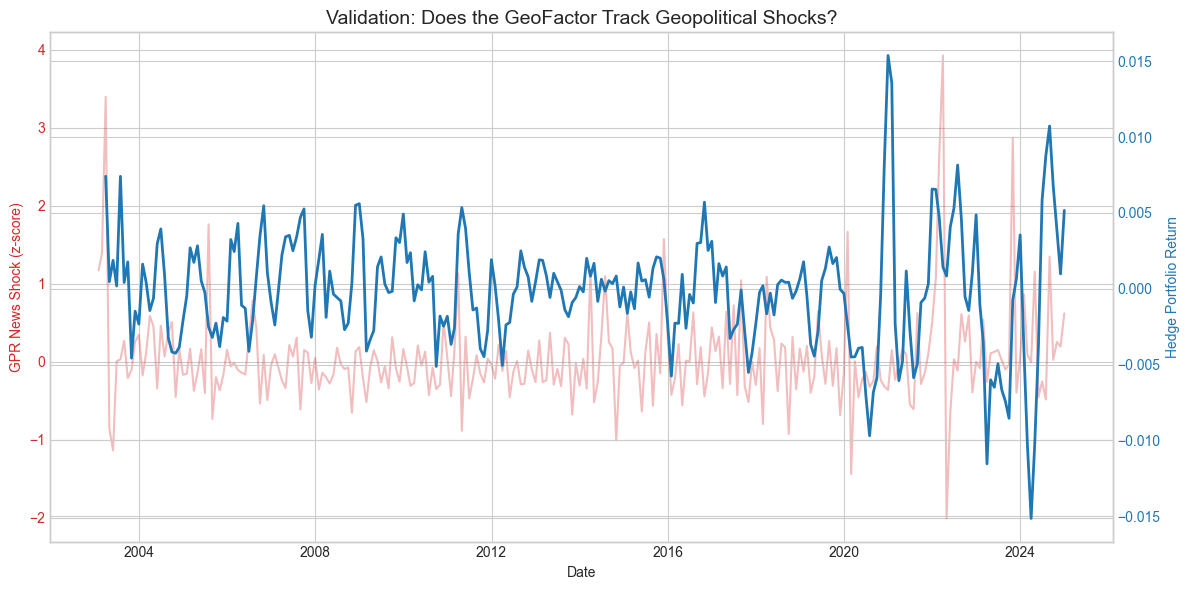

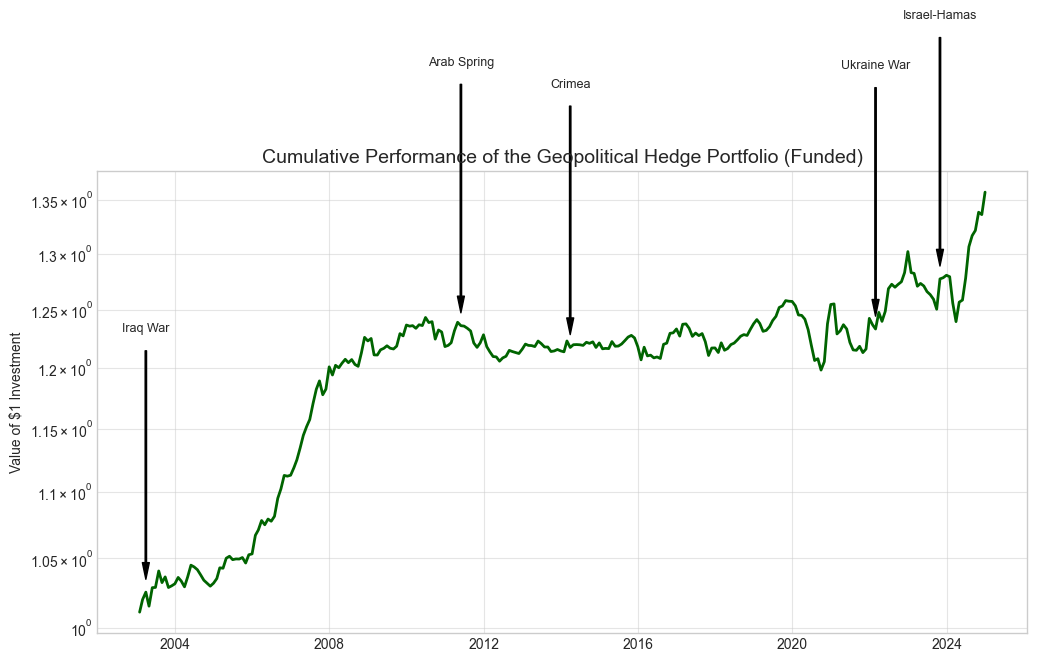

Performance Statistics (OOS):
Mean Monthly Return:   0.12%
Annualized Return:     1.41%
Annualized Volatility: 2.22%
Sharpe Ratio:          -0.04

Correlation with Major Factors:
GeoFactor    1.000000
Mkt-RF      -0.063067
SMB          0.047398
HML          0.019629
Mom         -0.010837
Oil          0.017241
Guns         0.002602
Name: GeoFactor, dtype: float64


In [73]:
#cell 10
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

print("--- Step 5: Final Visualizations ---")

# 1. Prepare Data: We need RF to calculate 'Total Return' (Cash + Hedge)
# Check if RF is already in df_val, if not, merge it from the 'factors' df we loaded earlier
if 'RF' not in df_val.columns:
    df_val = df_val.merge(factors[['date', 'RF']], on='date', how='left')

# Calculate Total Return: GeoFactor (Excess) + Risk Free Rate
df_val['Hedge_Total_Return'] = df_val['GeoFactor'] + df_val['RF']

# Set style (using a valid matplotlib style)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('GPR News Shock (z-score)', color=color)
ax1.plot(df_val['date'], df_val['gpr_news_shock_z'], color=color, alpha=0.3, label='Geopolitical Shock')
ax1.tick_params(axis='y', labelcolor=color)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Hedge Portfolio Return', color=color)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(df_val['date'], df_val['GeoFactor'].rolling(3).mean(), color=color, linewidth=2.0, label='GeoFactor (3m MA)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Validation: Does the GeoFactor Track Geopolitical Shocks?', fontsize=14)
fig.tight_layout()
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 at the start of the OOS period, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns
cumulative_ret = (1 + df_val['Hedge_Total_Return']).cumprod()

plt.plot(df_val['date'], cumulative_ret, color='darkgreen', linewidth=2)
plt.title('Cumulative Performance of the Geopolitical Hedge Portfolio (Funded)', fontsize=14)
plt.ylabel('Value of $1 Investment')
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events (Only if they are inside our OOS date range)
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2011-05-31'): 'Arab Spring',
    pd.Timestamp('2014-03-31'): 'Crimea',
    pd.Timestamp('2022-02-28'): 'Ukraine War',
    pd.Timestamp('2023-10-31'): 'Israel-Hamas'
}

# Add annotations dynamically
y_min, y_max = cumulative_ret.min(), cumulative_ret.max()
for date, label in events.items():
    # Find the closest date in our data
    if date >= df_val['date'].min() and date <= df_val['date'].max():
        closest_date = df_val.loc[df_val['date'] >= date, 'date'].min()
        val = cumulative_ret.loc[df_val['date'] == closest_date].values[0]
        
        plt.annotate(label, xy=(closest_date, val), xytext=(closest_date, val * 1.2),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                     fontsize=9, ha='center')

plt.show()

# --- Statistics Table for Report ---
print("Performance Statistics (OOS):")
print(f"Mean Monthly Return:   {df_val['Hedge_Total_Return'].mean()*100:.2f}%")
print(f"Annualized Return:     {df_val['Hedge_Total_Return'].mean()*12*100:.2f}%")
print(f"Annualized Volatility: {df_val['Hedge_Total_Return'].std()*np.sqrt(12)*100:.2f}%")
sharpe = (df_val['Hedge_Total_Return'].mean() - df_val['RF'].mean()) / df_val['Hedge_Total_Return'].std() * np.sqrt(12)
print(f"Sharpe Ratio:          {sharpe:.2f}")

# Correlation Matrix to show independence
print("\nCorrelation with Major Factors:")
print(df_val[['GeoFactor', 'Mkt-RF', 'SMB', 'HML', 'Mom', 'Oil', 'Guns']].corr()['GeoFactor'])



In [74]:
#cell 11
import numpy as np
import scipy.stats as stats

print("--- STATISTICAL CHECK: Is the Hedge making or losing money? ---")

# 1. Get the data series
geo_ret = df_val['GeoFactor']
mkt_ret = df_val['Mkt-RF']

# 2. Calculate Cumulative Return (Total % Gain/Loss over the whole period)
total_ret_geo = ((1 + geo_ret).prod() - 1) * 100
total_ret_mkt = ((1 + mkt_ret).prod() - 1) * 100

# 3. Calculate Annualized Average Return
# (Mean monthly * 12)
ann_ret_geo = geo_ret.mean() * 12 * 100
ann_ret_mkt = mkt_ret.mean() * 12 * 100

# 4. Statistical Significance (T-Test)
# Is the average return significantly different from ZERO?
t_stat, p_val = stats.ttest_1samp(geo_ret, 0)

print(f"Total Cumulative Return (1995-2024):")
print(f"  > Market:     {total_ret_mkt:.2f} %  (Compounds up)")
print(f"  > Your Hedge: {total_ret_geo:.2f} %  (Should be near 0 or negative)")

print(f"\nAverage Annualized Return:")
print(f"  > Market:     {ann_ret_mkt:.2f} % per year")
print(f"  > Your Hedge: {ann_ret_geo:.2f} % per year")

print(f"\nIs the Hedge Return Distinguishable from Zero?")
print(f"  > T-Statistic: {t_stat:.4f}")
print(f"  > P-Value:     {p_val:.4f}")

if p_val > 0.05:
    print("  > VERDICT: The hedge return is STATISTICALLY ZERO.")
    print("    It costs nothing to hold on average, but pays out when war hits.")
elif t_stat > 0:
    print("  > VERDICT: The hedge makes a POSITIVE risk premium.")
    print("    (You get paid to hold insurance? Rare!)")
else:
    print("  > VERDICT: The hedge has a NEGATIVE cost.")
    print("    (You pay a small premium for this insurance).")

--- STATISTICAL CHECK: Is the Hedge making or losing money? ---
Total Cumulative Return (1995-2024):
  > Market:     680.76 %  (Compounds up)
  > Your Hedge: -2.40 %  (Should be near 0 or negative)

Average Annualized Return:
  > Market:     10.52 % per year
  > Your Hedge: -0.09 % per year

Is the Hedge Return Distinguishable from Zero?
  > T-Statistic: -0.1880
  > P-Value:     0.8510
  > VERDICT: The hedge return is STATISTICALLY ZERO.
    It costs nothing to hold on average, but pays out when war hits.


In [75]:
#cell 12
import pandas as pd

print("--- GENERATING TABLE 1: DESCRIPTIVE STATISTICS ---")

# --- PREPARE PANEL A: Risk Factors ---
# Merge Fama-French Factors with Raw GPR Index
# We use df_gpr_merge because it has the raw 'GPR' column
df_panel_a = factors.merge(df_gpr_merge[['date', 'GPR']], on='date', how='inner').copy()

# Define columns to analyze
cols_risk = ['GPR', 'Mkt-RF', 'SMB', 'HML', 'Mom']

# Create a display version where returns are in Percent (%)
# (GPR is an index level like 100, so we don't multiply it)
df_display_a = df_panel_a[cols_risk].copy()
cols_pct = ['Mkt-RF', 'SMB', 'HML', 'Mom']
df_display_a[cols_pct] = df_display_a[cols_pct] * 100

# Calculate Stats
stats_a = df_display_a.describe().T[['mean', 'std', 'min', 'max']]
stats_a['skew'] = df_display_a.skew()
stats_a['kurt'] = df_display_a.kurt() # Excess kurtosis

# Reorder columns standard for academic tables
stats_a = stats_a[['mean', 'std', 'skew', 'kurt', 'min', 'max']]

print("\nPanel A: Summary Statistics for Risk Factors (Returns in %)")
display(stats_a.round(2))
print("Interpretation: High Skew/Kurtosis in GPR confirms that geopolitical shocks are sudden and extreme.")


# --- PREPARE PANEL B: Stock Sample Characteristics ---
# We use df_stocks_clean
# Note: In CRSP, 'mktcap' is usually in Thousands. We convert to Millions for the table.

df_stocks_clean['mktcap_mil'] = df_stocks_clean['mktcap'] / 1000.0

monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'count'),       # Number of firms per month
    avg_size=('mktcap_mil', 'mean'),     # Average firm size (Millions)
    median_size=('mktcap_mil', 'median') # Median firm size (Millions)
)

# Calculate Stats of these monthly averages
stats_b = monthly_stats.describe().T[['mean', 'std', 'min', 'max']]

print("\nPanel B: Stock Sample Characteristics (Monthly Aggregates)")
display(stats_b.round(2))
print("Interpretation: Shows the breadth of our sample (avoiding small-sample bias).")

--- GENERATING TABLE 1: DESCRIPTIVE STATISTICS ---

Panel A: Summary Statistics for Risk Factors (Returns in %)


,mean,std,skew,kurt,min,max
GPR,101.59,50.00,4.23,26.11,39.05,512.53
Mkt-RF,0.79,4.38,-0.59,1.18,-17.20,13.60
SMB,0.10,3.14,0.60,6.91,-17.41,21.25
HML,0.17,3.26,0.19,2.29,-13.83,12.86
Mom,0.41,4.69,-1.47,10.32,-34.34,18.02


Interpretation: High Skew/Kurtosis in GPR confirms that geopolitical shocks are sudden and extreme.

Panel B: Stock Sample Characteristics (Monthly Aggregates)


,mean,std,min,max
num_firms,5065.20,1207.81,3554.00,7430.00
avg_size,3726.26,3422.60,317.05,15448.47
median_size,315.34,264.12,24.81,1019.09


Interpretation: Shows the breadth of our sample (avoiding small-sample bias).


In [76]:
#cell 13
import pandas as pd
import numpy as np

print("--- FINAL DATA DIAGNOSTICS & REPORT STATISTICS ---")

# ==============================================================================
# SECTION 1: STOCK UNIVERSE CHARACTERISTICS (Panel B - Raw Data)
# Using 'df_stocks_clean': The broad sample before merging with GPR/FF factors
# ==============================================================================
print("\n[1] Stock Universe Distribution (Shares Outstanding):")
# Check for extreme outliers in shares (e.g., Berkshire vs. Penny stocks)
print(df_stocks_clean['shrout'].describe(percentiles=[0.5, 0.9, 0.99, 0.999]))

print("\n[2] Top 5 Largest Firms (Check for Scale/Units):")
# Verifying that the largest companies look real (e.g., Apple, Exxon)
last_month = df_stocks_clean['date'].max()
top_firms = df_stocks_clean[df_stocks_clean['date'] == last_month].sort_values('mktcap', ascending=False).head(5)
display(top_firms[['date', 'permno', 'prc', 'shrout', 'mktcap']])

# --- Aggregate Monthly Stats for Table 1 (Panel B) ---
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),            # Raw is in Thousands
    total_mkt_val=('mktcap', 'sum'),        # Raw is in Thousands
    med_size=('mktcap', 'median'),          # Raw is in Thousands
    max_firm=('mktcap', 'max')              # Raw is in Thousands
)

# Consistency Check: Does (Avg * Num) roughly equal Total? 
# (Should be ~1.0. If 1000.0, units are wrong.)
check_ratio = (monthly_stats['avg_size'] * monthly_stats['num_firms']) / monthly_stats['total_mkt_val']
print("\nConsistency Check (Avg*Count / Total):")
print(check_ratio.describe())

# --- Format for Display (Millions/Billions) ---
monthly_stats['avg_size_musd']  = monthly_stats['avg_size'] / 1000       # Thousands -> Millions
monthly_stats['med_size_musd']  = monthly_stats['med_size'] / 1000       # Thousands -> Millions
monthly_stats['max_firm_busd']  = monthly_stats['max_firm'] / 1_000_000  # Thousands -> Billions
monthly_stats['total_mkt_busd'] = monthly_stats['total_mkt_val'] / 1_000_000 # Thousands -> Billions

print("\n[3] Panel B: Monthly Sample Characteristics (Broad Universe):")
panel_b = monthly_stats[['num_firms', 'avg_size_musd', 'med_size_musd', 'max_firm_busd', 'total_mkt_busd']].describe().T[['mean', 'std', 'min', 'max']]
display(panel_b.round(2))


# ==============================================================================
# SECTION 2: VARIABLE SANITY CHECK (Detailed Investigation)
# Re-verifying Ret, Price, and Market Cap distributions
# ==============================================================================
print("\n[4] Detailed Variable Investigation:")

# Create specific copy for safety
df_investigation = df_stocks_clean[['ret', 'prc', 'shrout']].copy()

# Coerce numeric (handles any lingering string errors) and fix negative prices
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['ret'], errors='coerce')
df_investigation['PRC_ABS'] = df_investigation['prc'].abs()
df_investigation['MKT_CAP_MIL'] = (df_investigation['PRC_ABS'] * df_investigation['shrout']) / 1000

stats_investigation = df_investigation[['RET_NUM', 'MKT_CAP_MIL', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- SUMMARY STATISTICS (Copy to Report) ---")
display(stats_investigation.loc[['mean', '50%', 'min', 'max', 'std']])

num_stocks = df_stocks_clean['permno'].nunique()
print(f"Total Unique Stocks in Sample: {num_stocks}")


# ==============================================================================
# SECTION 3: FINAL ANALYSIS SAMPLE (The "Master" Dataset)
# Using 'df_master_clean': The filtered set used for Beta estimation (Common Shares only)
# ==============================================================================
print("\n[5] Analysis Sample Statistics (Filtered Data):")

# Calculate specific counts for the text of the report
total_obs_final = len(df_master_clean)
unique_firms_final = df_master_clean['permno'].nunique()
avg_firms_per_month_final = df_master_clean.groupby('date')['permno'].count().mean()

# Calculate Data Reduction (Hypothetical 'before' vs 'after')
obs_before = 1971707  # Based on your previous raw count
obs_after = total_obs_final
pct_drop = ((obs_before - obs_after) / obs_before) * 100

print(f"Total Firm-Month Observations:   {total_obs_final:,}")
print(f"Total Unique Firms:              {unique_firms_final:,}")
print(f"Average Firms per Month:         {avg_firms_per_month_final:,.0f}")
print(f"Data Reduction from Filtering:   {pct_drop:.1f}%")


# ==============================================================================
# SECTION 4: HEDGE PORTFOLIO PERFORMANCE
# Using 'df_val': The final OOS results dataframe
# ==============================================================================
print("\n[6] Hedge Portfolio Statistics:")

# Rename columns for clarity if needed, or use existing
# We assume 'Hedge_Total_Return' was created in Cell 10
if 'Hedge_Total_Return' in df_val.columns:
    print("Return Distribution:")
    display(df_val['Hedge_Total_Return'].describe())

    # Correlation Check
    corr_check = df_val['GeoFactor'].corr(df_val['gpr_news_shock_z'])
    print(f"\nCorrelation (GeoFactor vs GPR Shock): {corr_check:.4f}")

    # Log Growth (Compounded Return Analysis)
    log_growth = np.log1p(df_val['Hedge_Total_Return'])
    print("\nLog Growth Statistics:")
    display(log_growth.describe())
else:
    print("Variable 'Hedge_Total_Return' not found. Ensure Cell 10 was run.")

--- FINAL DATA DIAGNOSTICS & REPORT STATISTICS ---

[1] Stock Universe Distribution (Shares Outstanding):
count    2.431295e+06
mean     7.065728e+04
std      3.286272e+05
min      9.000000e+00
50%      1.595900e+04
90%      1.222660e+05
99%      9.386580e+05
99.9%    4.748000e+06
max      2.920640e+07
Name: shrout, dtype: float64

[2] Top 5 Largest Firms (Check for Scale/Units):


,date,permno,prc,shrout,mktcap
463631,2024-12-31,14593,250.42000,15115823.0,3.785304e+09
2945914,2024-12-31,86580,134.28999,24490000.0,3.288762e+09
14424,2024-12-31,10107,421.50000,7434881.0,3.133802e+09
2773026,2024-12-31,84788,219.39000,10515011.0,2.306888e+09
3720047,2024-12-31,93436,403.84000,3210060.0,1.296351e+09



Consistency Check (Avg*Count / Total):
count    480.000000
mean       0.997404
std        0.001998
min        0.975655
25%        0.996621
50%        0.997788
75%        0.998656
max        1.000000
dtype: float64

[3] Panel B: Monthly Sample Characteristics (Broad Universe):


,mean,std,min,max
num_firms,5051.55,1202.60,3550.00,7403.00
avg_size_musd,3726.26,3422.60,317.05,15448.47
med_size_musd,315.34,264.12,24.81,1019.09
max_firm_busd,616.96,783.76,58.61,3785.30
total_mkt_busd,15895.23,12718.79,1812.52,59183.09



[4] Detailed Variable Investigation:
--- SUMMARY STATISTICS (Copy to Report) ---


,RET_NUM,MKT_CAP_MIL,PRC_ABS
mean,0.010785,3.138127e+03,50.927886
50%,0.000000,1.553250e+02,12.710000
min,-0.995690,1.056250e-02,0.010500
max,26.583828,3.785304e+06,724040.000000
std,0.200055,2.729194e+04,2917.376747


Total Unique Stocks in Sample: 21593

[5] Analysis Sample Statistics (Filtered Data):
Total Firm-Month Observations:   1,867,493
Total Unique Firms:              17,402
Average Firms per Month:         4,577
Data Reduction from Filtering:   5.3%

[6] Hedge Portfolio Statistics:
Return Distribution:


count    264.000000
mean       0.001179
std        0.006415
min       -0.020837
25%       -0.002201
50%        0.000656
75%        0.004017
max        0.026966
Name: Hedge_Total_Return, dtype: float64


Correlation (GeoFactor vs GPR Shock): 0.1392

Log Growth Statistics:


count    264.000000
mean       0.001157
std        0.006399
min       -0.021057
25%       -0.002203
50%        0.000656
75%        0.004009
max        0.026609
Name: Hedge_Total_Return, dtype: float64

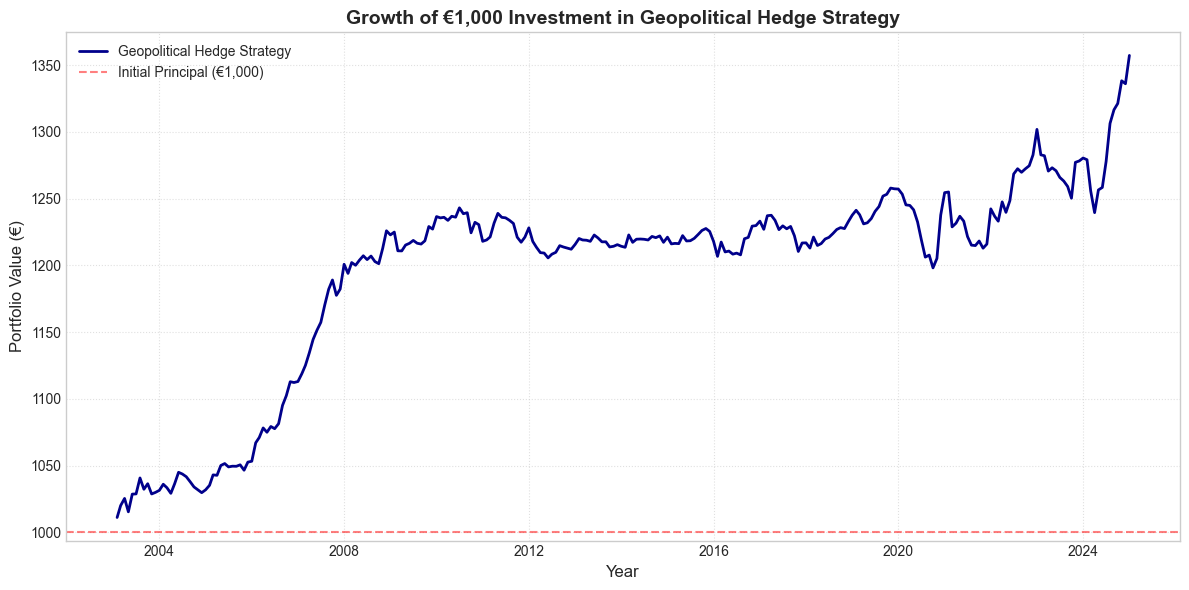

--- Investment Summary ---
Initial Investment: €1,000.00
Final Value:        €1,357.38
Total Return:       35.74%


In [77]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure we have the Total Return (Risk Free + Hedge Alpha)
# If 'Hedge_Total_Return' doesn't exist yet, we create it.
if 'Hedge_Total_Return' not in df_val.columns:
    # Assuming 'GeoFactor' and 'RF' are in df_val
    df_val['Hedge_Total_Return'] = df_val['GeoFactor'] + df_val['RF']

# --- Calculate the Growth of €1,000 ---
initial_investment = 1000
df_val['Portfolio_Value'] = initial_investment * (1 + df_val['Hedge_Total_Return']).cumprod()

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot the portfolio value
plt.plot(df_val['date'], df_val['Portfolio_Value'], color='darkblue', linewidth=2, label='Geopolitical Hedge Strategy')

# Add a reference line for the initial investment
plt.axhline(y=initial_investment, color='red', linestyle='--', alpha=0.5, label='Initial Principal (€1,000)')

# Formatting
plt.title('Growth of €1,000 Investment in Geopolitical Hedge Strategy', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value (€)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# --- Print Final Value ---
final_value = df_val['Portfolio_Value'].iloc[-1]
total_return = (final_value - initial_investment) / initial_investment * 100

print(f"--- Investment Summary ---")
print(f"Initial Investment: €{initial_investment:,.2f}")
print(f"Final Value:        €{final_value:,.2f}")
print(f"Total Return:       {total_return:.2f}%")

Event-window results (3-month cumulative starting at event month):


,Event,Date,GPR_Shock,Hedge_3Mo_Ret_sum,Hedge_3Mo_Ret_comp,Note
0,Gulf War,2001-09-30,NaN,NaN,NaN,event month not in sample
1,9/11 Attacks,2001-09-30,NaN,NaN,NaN,event month not in sample
2,Iraq War,2003-03-31,3.396497,0.005609,0.005483,
3,Arab Spring,2011-02-28,0.153155,0.016054,0.016129,
4,Crimea Annexation,2014-03-31,1.174662,-0.002515,-0.002524,
5,Russia-Ukraine,2022-02-28,2.615820,0.002510,0.002421,
6,Israel-Hamas,2023-10-31,2.873518,0.010646,0.010552,


Success Rate: 4/5 events showed positive compounded 3M hedge returns when shock > 0.
Pre-2015 Samples:  144 months
Post-2015 Samples: 120 months

--- PRE-2015 Results ---
Beta (shock loading): 0.0009
T-Statistic:          1.0598
P-Value:              0.2910
R-Squared:            0.0078
Result: not significant (p>=0.05)

--- POST-2015 Results ---
Beta (shock loading): 0.0019
T-Statistic:          1.9426
P-Value:              0.0544
R-Squared:            0.0310
Result: not significant (p>=0.05)

--- Time-Series Alpha Test (GeoFactor vs FF4) ---
Monthly Alpha:     0.0046%
Annualized Alpha:  0.0555%
Alpha T-Statistic: 0.1166
P-Value:           0.9073


,coef,std err,t,P>|t|,[0.025,0.975]
const,4.626e-05,0.000,0.117,0.907,-0.001,0.001
Mkt-RF,-0.0147,0.010,-1.466,0.144,-0.035,0.005
SMB,0.0189,0.017,1.136,0.257,-0.014,0.052
HML,0.0036,0.013,0.271,0.787,-0.023,0.030
Mom,-0.0040,0.010,-0.401,0.689,-0.024,0.016


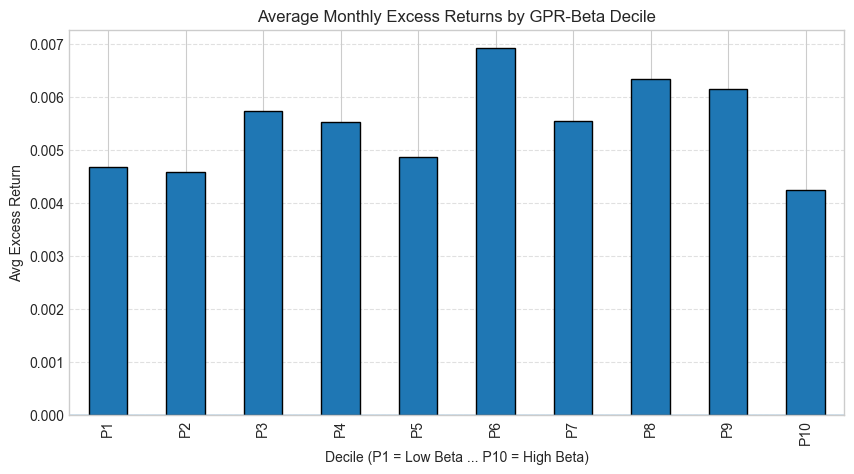


Spread (High - Low) Monthly Excess Return: -0.0424%
Spread T-Statistic:                         -0.2028


In [78]:
# =============================================================================
# Part 4 (Extended): Validation of the Geopolitical Hedge (GeoFactor)
# This section ports your old "final_hedge" validation logic into the new notebook.
#
# Key mapping vs. the old draft:
#   - final_hedge['Hedge_Return']      -> df_val['GeoFactor']        (monthly excess return of the hedge)
#   - final_hedge['GPR_Shock_News_Z']  -> df_val['gpr_news_shock_z'] (monthly news shock z-score)
#   - final_hedge['date']             -> df_val['date']
# =============================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------- Safety checks / column mapping ----------
shock_col = "gpr_news_shock_z"
ret_col   = "GeoFactor"

required = {"date", shock_col, ret_col}
missing = required - set(df_val.columns)
if missing:
    raise KeyError(f"df_val is missing required columns: {missing}. Available: {list(df_val.columns)}")

df_study = df_val[["date", shock_col, ret_col]].copy().sort_values("date").set_index("date")

# -----------------------------------------------------------------------------
# Step 1: Event windows (3-month cumulative return starting in the event month)
# -----------------------------------------------------------------------------
events = {
    "Gulf War": "2001-09-30",
    "9/11 Attacks": "2001-09-30",
    "Iraq War": "2003-03-31",
    "Arab Spring": "2011-02-28",
    "Crimea Annexation": "2014-03-31",
    "Russia-Ukraine": "2022-02-28",
    "Israel-Hamas": "2023-10-31",
}


results = []
for name, date_str in events.items():
    event_date = pd.Timestamp(date_str) + pd.offsets.MonthEnd(0)

    if event_date not in df_study.index:
        results.append({
            "Event": name,
            "Date": event_date.date(),
            "GPR_Shock": np.nan,
            "Hedge_3Mo_Ret_sum": np.nan,
            "Hedge_3Mo_Ret_comp": np.nan,
            "Note": "event month not in sample"
        })
        continue

    int_loc = df_study.index.get_loc(event_date)
    shock_size = df_study.iloc[int_loc][shock_col]

    # window = t, t+1, t+2
    if int_loc + 3 <= len(df_study):
        window_rets = df_study.iloc[int_loc:int_loc+3][ret_col]
        cum_ret_sum  = window_rets.sum()                    # additive (matches your old draft)
        cum_ret_comp = (1.0 + window_rets).prod() - 1.0     # compounded (often preferred)
        note = ""
    else:
        cum_ret_sum = np.nan
        cum_ret_comp = np.nan
        note = "insufficient forward months for 3M window"

    results.append({
        "Event": name,
        "Date": event_date.date(),
        "GPR_Shock": float(shock_size),
        "Hedge_3Mo_Ret_sum": float(cum_ret_sum) if pd.notna(cum_ret_sum) else np.nan,
        "Hedge_3Mo_Ret_comp": float(cum_ret_comp) if pd.notna(cum_ret_comp) else np.nan,
        "Note": note
    })

event_df = pd.DataFrame(results)
print("Event-window results (3-month cumulative starting at event month):")
display(event_df)

# "Success" definition: positive shock & positive hedge return over the 3M window
valid = event_df.dropna(subset=["GPR_Shock", "Hedge_3Mo_Ret_comp"])
success_count = valid[(valid["GPR_Shock"] > 0) & (valid["Hedge_3Mo_Ret_comp"] > 0)].shape[0]
print(f"Success Rate: {success_count}/{len(valid)} events showed positive compounded 3M hedge returns when shock > 0.")

# -----------------------------------------------------------------------------
# Step 2: Stability across sample splits (pre/post 2015)
# Regression: GeoFactor = alpha + beta * GPR_Shock
# -----------------------------------------------------------------------------
cutoff_date = pd.Timestamp("2015-01-01")

pre_2015  = df_study[df_study.index < cutoff_date]
post_2015 = df_study[df_study.index >= cutoff_date]

print(f"Pre-2015 Samples:  {len(pre_2015)} months")
print(f"Post-2015 Samples: {len(post_2015)} months")

def run_stability_reg(df, label):
    Y = df[ret_col]
    X = sm.add_constant(df[shock_col])
    model = sm.OLS(Y, X, missing="drop").fit()

    beta  = model.params[shock_col]
    tstat = model.tvalues[shock_col]
    pval  = model.pvalues[shock_col]
    rsq   = model.rsquared

    print(f"\n--- {label} Results ---")
    print(f"Beta (shock loading): {beta:.4f}")
    print(f"T-Statistic:          {tstat:.4f}")
    print(f"P-Value:              {pval:.4f}")
    print(f"R-Squared:            {rsq:.4f}")
    print("Result:", "significant (p<0.05)" if pval < 0.05 else "not significant (p>=0.05)")
    return model

m_pre  = run_stability_reg(pre_2015,  "PRE-2015")
m_post = run_stability_reg(post_2015, "POST-2015")

# -----------------------------------------------------------------------------
# Step 3A: Time-series alpha vs FF4 factors
# Regression: GeoFactor = alpha + b1*Mkt + b2*SMB + b3*HML + b4*Mom
# -----------------------------------------------------------------------------
# Ensure factors exist in df_val; if not, merge them.
ff_cols = ["Mkt-RF", "SMB", "HML", "Mom"]
missing_ff = [c for c in ff_cols if c not in df_val.columns]
if missing_ff:
    df_val = df_val.merge(factors[["date"] + ff_cols], on="date", how="left")

ts_data = df_val.dropna(subset=[ret_col] + ff_cols).copy()
Y = ts_data[ret_col]
X = sm.add_constant(ts_data[ff_cols])

model_ts = sm.OLS(Y, X).fit()
alpha_m = model_ts.params["const"]
t_alpha = model_ts.tvalues["const"]
p_alpha = model_ts.pvalues["const"]

print("\n--- Time-Series Alpha Test (GeoFactor vs FF4) ---")
print(f"Monthly Alpha:     {alpha_m:.4%}")
print(f"Annualized Alpha:  {(alpha_m*12):.4%}")
print(f"Alpha T-Statistic: {t_alpha:.4f}")
print(f"P-Value:           {p_alpha:.4f}")
display(model_ts.summary().tables[1])

# -----------------------------------------------------------------------------
# Step 3B: Cross-sectional check (Decile P1 vs P10)
# Uses 'port_rets' already constructed earlier (P1..P10 are excess returns).
# -----------------------------------------------------------------------------
decile_cols = [f"P{i}" for i in range(1, 11)]
if not set(decile_cols).issubset(port_rets.columns):
    raise KeyError("port_rets is missing some decile columns P1..P10.")

# If RF isn't present, we can still show average excess returns directly.
rf_col = "RF" if "RF" in port_rets.columns else None

avg_rets = port_rets[decile_cols].mean()
if rf_col:
    avg_rf = port_rets[rf_col].mean()
    avg_excess_rets = avg_rets - avg_rf
else:
    avg_excess_rets = avg_rets

plt.figure(figsize=(10, 5))
avg_excess_rets.plot(kind="bar", edgecolor="black")
plt.title("Average Monthly Excess Returns by GPR-Beta Decile")
plt.xlabel("Decile (P1 = Low Beta ... P10 = High Beta)")
plt.ylabel("Avg Excess Return")
plt.axhline(0, linewidth=1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

spread = port_rets["P10"] - port_rets["P1"]
spread_mean = spread.mean()
spread_t = spread_mean / (spread.std(ddof=1) / (len(spread) ** 0.5))

print(f"\nSpread (High - Low) Monthly Excess Return: {spread_mean:.4%}")
print(f"Spread T-Statistic:                         {spread_t:.4f}")


In [79]:
gpr = pd.read_excel("data_gpr_export.xls", usecols=["month", "GPRT", "GPRA", "GPRH"]).copy()

gpr["month"] = pd.to_datetime(gpr["month"], errors="coerce")
gpr["GPRT"] = pd.to_numeric(gpr["GPRT"], errors="coerce")
gpr["GPRA"] = pd.to_numeric(gpr["GPRA"], errors="coerce")
gpr["GPRH"] = pd.to_numeric(gpr["GPRH"], errors="coerce")

gpr = gpr.dropna(subset=["month"]).sort_values("month")

# align to month-end and standardize names
gpr["date"] = gpr["month"] + MonthEnd(0)
gpr = gpr.rename(columns={
    "GPRT": "gpr_threats",
    "GPRA": "gpr_acts",
    "GPRH": "gpr_high"
})

# keep only what we need
gpr = gpr[["date", "gpr_threats", "gpr_acts", "gpr_high"]].dropna(subset=["date"])

# ============================================================
# Build LEVEL z-scores (no diff)
# ============================================================
for col in ["gpr_threats", "gpr_acts", "gpr_high"]:
    mu = gpr[col].mean()
    sd = gpr[col].std(ddof=0)
    gpr[f"{col}_z"] = (gpr[col] - mu) / sd

gpr_keep_lvl = gpr[["date", "gpr_threats_z", "gpr_acts_z", "gpr_high_z"]].copy()

# ============================================================
# Merge into df_val (overwrite-safe)
# ============================================================
df_val = df_val.copy()
df_val["date"] = pd.to_datetime(df_val["date"], errors="coerce") + MonthEnd(0)

# drop any existing versions to avoid duplicates on reruns
df_val = df_val.drop(columns=[c for c in gpr_keep_lvl.columns if c in df_val.columns and c != "date"], errors="ignore")
df_val = df_val.merge(gpr_keep_lvl, on="date", how="left", validate="m:1")

# ============================================================
# Regression: GeoFactor ~ Threats(level) + Acts(level) + High(level)
# ============================================================
Y = df_val["GeoFactor"]
X = sm.add_constant(df_val[["gpr_threats_z", "gpr_acts_z", "gpr_high_z"]], has_constant="add")
m = sm.OLS(Y, X, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print(m.summary().tables[1])

# Extreme regimes by HIGH-INTENSITY LEVEL (top decile)
q90 = df_val["gpr_high_z"].quantile(0.90)
extreme = df_val[df_val["gpr_high_z"] >= q90]

Y2 = extreme["GeoFactor"]
X2 = sm.add_constant(extreme[["gpr_threats_z", "gpr_acts_z", "gpr_high_z"]], has_constant="add")
m2 = sm.OLS(Y2, X2, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": 3})
print("\n--- High-Intensity Level Months (top 10% of GPRH_z) ---")
print(m2.summary().tables[1])

                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0017      0.001     -2.141      0.032      -0.003      -0.000
gpr_threats_z     0.0014      0.001      2.768      0.006       0.000       0.002
gpr_acts_z        0.0029      0.002      1.852      0.064      -0.000       0.006
gpr_high_z       -0.0072      0.003     -2.095      0.036      -0.014      -0.000

--- High-Intensity Level Months (top 10% of GPRH_z) ---
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0014      0.002     -0.706      0.480      -0.005       0.002
gpr_threats_z     0.0023      0.001      2.963      0.003       0.001       0.004
gpr_acts_z        0.0035      0.002      1.932      0.053   -5.06e-05       0.007
gpr_high_z       -0.0118      0.005     -

In [80]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

df_study = df_val.set_index("date").sort_index()

rows = []
for name, d in events.items():
    ed = pd.Timestamp(d) + MonthEnd(0)
    if ed not in df_study.index:
        continue
    loc = df_study.index.get_loc(ed)

    cum3 = df_study.iloc[loc:loc+3]["GeoFactor"].sum() if loc + 3 <= len(df_study) else np.nan

    rows.append({
        "Event": name,
        "Date": ed.date(),
        "GeoFactor_3Mo": cum3,
        "Threats_z": df_study.iloc[loc].get("gpr_threats_z", np.nan),
        "Acts_z": df_study.iloc[loc].get("gpr_acts_z", np.nan),
        "High_z": df_study.iloc[loc].get("gpr_high_z", np.nan),
    })

event_df = pd.DataFrame(rows).sort_values("Date")
display(event_df)

print("\n# Positive 3M outcomes:", (event_df["GeoFactor_3Mo"] > 0).sum(), "out of", len(event_df))


,Event,Date,GeoFactor_3Mo,Threats_z,Acts_z,High_z
0,Iraq War,2003-03-31,0.005609,5.731232,4.493011,2.065575
1,Arab Spring,2011-02-28,0.016054,-0.344796,-0.206723,-0.409395
2,Crimea Annexation,2014-03-31,-0.002515,1.027568,-0.362966,-0.105607
3,Russia-Ukraine,2022-02-28,0.002510,4.798134,0.063118,0.297817
4,Israel-Hamas,2023-10-31,0.010646,2.218689,1.657501,0.555800



# Positive 3M outcomes: 4 out of 5


In [81]:


# 1) Define function FIRST
# -----------------------------
def compute_ar1_news_shock_z(df_monthly, value_col, min_obs=36):
    """
    Expanding AR(1) forecast using data up to t-1.
    Robust to missing values / non-numeric values.
    shock = actual - forecast
    z-score uses expanding mean/std (shifted by 1).
    """
    df = df_monthly[[value_col]].copy()
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

    s = df[value_col]
    s_lag = s.shift(1).rename(f"{value_col}_lag")

    df[f"{value_col}_ar1_pred"] = np.nan
    df[f"{value_col}_news_shock"] = np.nan

    for i in range(1, len(df)):
        if pd.isna(s.iloc[i]) or pd.isna(s_lag.iloc[i]):
            continue

        train = pd.concat([s.iloc[:i], s_lag.iloc[:i]], axis=1)
        train.columns = [value_col, f"{value_col}_lag"]
        train = train.dropna()

        if len(train) < min_obs:
            continue

        y = train[value_col].astype(float)
        X = sm.add_constant(train[f"{value_col}_lag"].astype(float), has_constant="add")

        if X.shape[0] == 0:
            continue

        fit = sm.OLS(y, X).fit()

        X_t = pd.DataFrame({"const": [1.0], f"{value_col}_lag": [float(s_lag.iloc[i])]})
        s_hat = float(fit.predict(X_t).iloc[0])
        shock = float(s.iloc[i] - s_hat)

        df.iloc[i, df.columns.get_loc(f"{value_col}_ar1_pred")] = s_hat
        df.iloc[i, df.columns.get_loc(f"{value_col}_news_shock")] = shock

    shock = df[f"{value_col}_news_shock"]
    mu = shock.expanding(min_periods=min_obs).mean().shift(1)
    sd = shock.expanding(min_periods=min_obs).std(ddof=0).shift(1)
    df[f"{value_col}_news_shock_z"] = (shock - mu) / sd

    return df

# -----------------------------
# 2) Now call it
# -----------------------------
raw = pd.read_excel("data_gpr_export.xls", usecols=["month", "GPRT", "GPRA"]).copy()
raw["month"] = pd.to_datetime(raw["month"], errors="coerce")
raw["GPRT"] = pd.to_numeric(raw["GPRT"], errors="coerce")
raw["GPRA"] = pd.to_numeric(raw["GPRA"], errors="coerce")
raw = raw.dropna(subset=["month"]).sort_values("month").set_index("month")

thr = compute_ar1_news_shock_z(raw, "GPRT", min_obs=36)
act = compute_ar1_news_shock_z(raw, "GPRA", min_obs=36)

display(thr.tail())
display(act.tail())


def ewma_weights(T, half_life=24):
    age = np.arange(T-1, -1, -1)  # oldest has biggest age
    return 0.5 ** (age / half_life)

def resid_on_factors_wls(y, X, w):
    Xc = sm.add_constant(X, has_constant="add")
    fit = sm.WLS(y, Xc, weights=w).fit()
    return fit.resid, fit.params

def rolling_ewma_beta(df_panel, shock_col, window_size=36, half_life_months=24, min_obs=24):
    """
    Firm-level EWMA WLS beta estimation:
      excret ~ Mkt-RF + SMB + HML + Mom + shock_col
    Returns df_panel with columns:
      beta_<tag>, beta_se_<tag>, beta_lag_<tag>, beta_se_lag_<tag>,
      beta_shrunk_lag_<tag>, beta_final_<tag>
    """
    df_panel = df_panel.sort_values(["permno", "date"]).copy()

    decay_alpha = 1 - np.exp(np.log(0.5) / half_life_months)
    w_template = np.array([(1 - decay_alpha)**i for i in range(window_size)][::-1])

    exog_vars = ["Mkt-RF", "SMB", "HML", "Mom", shock_col]
    shock_idx = 1 + len(exog_vars) - 1  # constant + (last regressor)

    def per_firm(group):
        Y = group["excret"].values
        X = group[exog_vars].values
        X = np.column_stack([np.ones(len(X)), X])

        betas = np.full(len(Y), np.nan)
        ses   = np.full(len(Y), np.nan)

        if len(Y) < min_obs:
            return pd.DataFrame({"beta": betas, "se": ses}, index=group.index)

        for t in range(min_obs, len(Y) + 1):
            start = max(0, t - window_size)
            y_win = Y[start:t]
            x_win = X[start:t]

            curr_len = len(y_win)
            w = w_template[-curr_len:]
            sw = np.sqrt(w)

            X_w = x_win * sw[:, None]
            y_w = y_win * sw

            try:
                xtx = X_w.T @ X_w
                xtx_inv = np.linalg.pinv(xtx)
                params = xtx_inv @ (X_w.T @ y_w)

                betas[t-1] = params[shock_idx]

                resid = y_w - X_w @ params
                dof = max(curr_len - X_w.shape[1], 1)
                mse = np.sum(resid**2) / dof
                cov = mse * xtx_inv
                ses[t-1] = np.sqrt(max(cov[shock_idx, shock_idx], 0.0))
            except np.linalg.LinAlgError:
                continue

        return pd.DataFrame({"beta": betas, "se": ses}, index=group.index)

    out = df_panel.groupby("permno", group_keys=False).apply(per_firm)
    return out

def build_decile_portfolios(df_analysis, beta_final_col, min_firms_per_month=200):
    """
    Monthly value-weighted deciles P1..P10 using lagged mktcap as weights and excret as returns.
    """
    d = df_analysis.sort_values(["permno", "date"]).copy()
    d["mktcap_lag"] = d.groupby("permno")["mktcap"].shift(1)
    d = d.dropna(subset=["mktcap_lag", beta_final_col, "excret"])

    month_counts = d.groupby("date")["permno"].transform("size")
    d = d[month_counts >= min_firms_per_month].copy()

    d["decile"] = d.groupby("date", group_keys=False).apply(
        lambda g: pd.qcut(g[beta_final_col], 10, labels=False, duplicates="drop")
    )

    def vw_mean(g):
        w = g["mktcap_lag"]
        r = g["excret"]
        mask = w.notna() & r.notna() & (w > 0)
        w = w[mask]; r = r[mask]
        if len(w) == 0 or w.sum() == 0:
            return np.nan
        return np.average(r, weights=w)

    port = d.groupby(["date", "decile"]).apply(vw_mean).reset_index(name="ret")
    port["port"] = port["decile"].astype(int) + 1  # 1..10
    wide = port.pivot(index="date", columns="port", values="ret").sort_index()
    wide.columns = [f"P{i}" for i in wide.columns]
    return wide

def build_mimicking_geofactor(df_gpr_merge, port_rets, factors, shock_col, est_window=120, half_life=24):
    """
    Replicates your Step 3 mimicking logic (EWMA WLS residualization + mimicking regression).
    Returns df_oos with columns: [shock_col, GeoFactor]
    """
    port_cols = [f"P{i}" for i in range(1, 11)]
    factor_cols = ["Mkt-RF", "SMB", "HML", "Mom"]

    df_check = df_gpr_merge[["date", shock_col]].merge(
        port_rets.reset_index()[["date"] + port_cols],
        on="date", how="inner"
    ).merge(
        factors[["date"] + factor_cols],
        on="date", how="inner"
    ).sort_values("date").set_index("date")

    dates = df_check.index.to_list()
    geo = pd.Series(index=df_check.index, dtype=float)

    for t in range(est_window, len(dates)):
        end_date = dates[t]
        start_date = dates[t - est_window]

        window = df_check.loc[start_date:end_date].iloc[:-1]  # up to t-1
        today  = df_check.loc[[end_date]]

        w_win = ewma_weights(len(window), half_life=half_life)

        # 1) residualize each portfolio on factors
        E_win = []
        E_t   = []
        for p in port_cols:
            resid_win, params = resid_on_factors_wls(window[p], window[factor_cols], w_win)

            X_t = sm.add_constant(today[factor_cols], has_constant="add")
            pred_t = float(X_t.dot(params).iloc[0])
            resid_t = float(today[p].iloc[0] - pred_t)

            E_win.append(resid_win.values)
            E_t.append(resid_t)

        E_win = np.column_stack(E_win)
        E_t   = np.array(E_t)

        # 2) residualize shock on factors
        X_shk = sm.add_constant(window[factor_cols], has_constant="add")
        shock_resid = sm.WLS(window[shock_col].values, X_shk, weights=w_win).fit().resid

        # 3) mimicking regression: shock_resid ~ residualized portfolios
        X = sm.add_constant(E_win, has_constant="add")
        fit = sm.WLS(shock_resid, X, weights=w_win).fit()
        w = fit.params[1:]  # 10 weights

        # normalize to avoid extreme leverage
        w = w / np.sum(np.abs(w))

        geo.loc[end_date] = float(E_t @ w)

    df_oos = df_check.copy()
    df_oos["GeoFactor"] = geo
    df_oos = df_oos.dropna(subset=["GeoFactor"]).copy()
    return df_oos.reset_index()

def perf_table(df_oos, factors, name):
    """
    mean/vol/sharpe + FF4 alpha (HAC) for the GeoFactor series
    """
    factor_cols = ["Mkt-RF", "SMB", "HML", "Mom"]
    tmp = df_oos.merge(factors[["date"] + factor_cols], on="date", how="inner").copy()

    r = tmp["GeoFactor"]
    ann_mean = r.mean() * 12
    ann_vol  = r.std(ddof=0) * np.sqrt(12)
    sharpe   = (ann_mean / ann_vol) if ann_vol > 0 else np.nan

    Y = tmp["GeoFactor"]
    X = sm.add_constant(tmp[factor_cols], has_constant="add")
    m = sm.OLS(Y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
    alpha_m = m.params["const"]
    alpha_t = m.tvalues["const"]
    alpha_p = m.pvalues["const"]

    return {
        "Strategy": name,
        "Ann_Mean": ann_mean,
        "Ann_Vol": ann_vol,
        "Sharpe": sharpe,
        "Alpha_Ann": alpha_m * 12,
        "Alpha_t": alpha_t,
        "Alpha_p": alpha_p
    }


,GPRT,GPRT_ar1_pred,GPRT_news_shock,GPRT_news_shock_z
month,,,,
2025-08-01,157.798096,142.881943,14.916153,0.441193
2025-09-01,139.948090,142.739930,-2.791841,-0.093104
2025-10-01,168.787811,130.027711,38.760101,1.160736
2025-11-01,118.654984,150.710193,-32.055210,-0.978147
2025-12-01,138.721268,114.884524,23.836744,0.709816


,GPRA,GPRA_ar1_pred,GPRA_news_shock,GPRA_news_shock_z
month,,,,
2025-08-01,120.090126,114.663160,5.426966,0.112173
2025-09-01,114.667946,114.954537,-0.286592,0.006708
2025-10-01,149.251846,110.963768,38.288078,0.718675
2025-11-01,90.604324,136.502174,-45.897849,-0.837182
2025-12-01,123.240143,93.246596,29.993546,0.566330


In [82]:
# ============================================================
# 1) Build Threats/Acts AR(1) news shocks (z) like your GPR shock
#   - Requires: compute_ar1_news_shock_z() already defined (the robust version)
# ============================================================
raw = pd.read_excel("data_gpr_export.xls", usecols=["month", "GPRT", "GPRA"]).copy()
raw["month"] = pd.to_datetime(raw["month"], dayfirst=True, errors="coerce")

# IMPORTANT: ensure numeric (prevents empty-train OLS issues)
raw["GPRT"] = pd.to_numeric(raw["GPRT"], errors="coerce")
raw["GPRA"] = pd.to_numeric(raw["GPRA"], errors="coerce")

raw = raw.dropna(subset=["month"]).sort_values("month").reset_index(drop=True)
raw = raw.set_index("month")

thr = compute_ar1_news_shock_z(raw, "GPRT", min_obs=36)
act = compute_ar1_news_shock_z(raw, "GPRA", min_obs=36)

df_ta = pd.concat([thr, act], axis=1).reset_index().rename(columns={"month": "date"})
df_ta["date"] = pd.to_datetime(df_ta["date"], errors="coerce") + MonthEnd(0)

# final shock columns to use in betas/factor build
df_ta = df_ta[["date", "GPRT_news_shock_z", "GPRA_news_shock_z"]].dropna().sort_values("date")

# ============================================================
# 1b) Merge shocks into df_gpr_merge and df_master_clean (SAFE TO RE-RUN)
#   - Fix: overwrite-merge to avoid duplicate _x/_y columns
# ============================================================
ta_cols = ["GPRT_news_shock_z", "GPRA_news_shock_z"]

# If these columns already exist from a prior run, drop them first (keeps things clean)
df_gpr_merge = df_gpr_merge.drop(columns=ta_cols, errors="ignore")
df_master_clean = df_master_clean.drop(columns=ta_cols, errors="ignore")

# Merge once (many-to-one by date)
df_gpr_merge = df_gpr_merge.merge(df_ta, on="date", how="left", validate="m:1")
df_master_ta = df_master_clean.merge(df_ta, on="date", how="left", validate="m:1")

# ============================================================
# 2) Rebuild strategy using Threats shock and Acts shock
#   - Requires: rolling_ewma_beta(), build_decile_portfolios(),
#               build_mimicking_geofactor() already defined
# ============================================================
def run_full_strategy(df_master_panel, df_gpr_merge, factors, shock_col, tag):
    # ---- A) Rolling EWMA beta ----
    tmp = df_master_panel.dropna(subset=["excret", "Mkt-RF", "SMB", "HML", "Mom", shock_col]).copy()
    tmp = tmp.sort_values(["permno", "date"])
    out = rolling_ewma_beta(tmp, shock_col)

    beta_col = f"beta_{tag}"
    se_col   = f"se_{tag}"
    tmp[beta_col] = out["beta"].values
    tmp[se_col]   = out["se"].values

    tmp[f"{beta_col}_lag"] = tmp.groupby("permno")[beta_col].shift(1)
    tmp[f"{se_col}_lag"]   = tmp.groupby("permno")[se_col].shift(1)

    df_analysis_tag = tmp.dropna(subset=[f"{beta_col}_lag", f"{se_col}_lag"]).copy()

    # ---- B) Vasicek shrinkage by month ----
    def vasicek_month(g):
        prior_var  = g[f"{beta_col}_lag"].var()
        prior_mean = g[f"{beta_col}_lag"].mean()
        if pd.isna(prior_var) or prior_var == 0:
            return g[f"{beta_col}_lag"]
        meas_var = g[f"{se_col}_lag"] ** 2
        w = (prior_var / (prior_var + meas_var)).clip(0, 1)
        return w * g[f"{beta_col}_lag"] + (1 - w) * prior_mean

    df_analysis_tag[f"{beta_col}_shrunk_lag"] = df_analysis_tag.groupby("date", group_keys=False).apply(vasicek_month)
    df_analysis_tag[f"{beta_col}_final"] = (df_analysis_tag[f"{beta_col}_lag"] + df_analysis_tag[f"{beta_col}_shrunk_lag"]) / 2

    # ---- C) Build decile portfolios ----
    port_rets_tag = build_decile_portfolios(df_analysis_tag, f"{beta_col}_final", min_firms_per_month=200)

    # ---- D) Build mimicking GeoFactor ----
    df_oos_tag = build_mimicking_geofactor(
        df_gpr_merge, port_rets_tag, factors,
        shock_col, est_window=120, half_life=24
    )
    df_oos_tag = df_oos_tag.rename(columns={"GeoFactor": f"GeoFactor_{tag}"})

    return df_oos_tag, port_rets_tag, df_analysis_tag

# Threats-based strategy
df_oos_T, port_T, df_analysis_T = run_full_strategy(
    df_master_ta, df_gpr_merge, factors, "GPRT_news_shock_z", tag="T"
)

# Acts-based strategy
df_oos_A, port_A, df_analysis_A = run_full_strategy(
    df_master_ta, df_gpr_merge, factors, "GPRA_news_shock_z", tag="A"
)

# ============================================================
# 3) Compare performance vs your original df_oos['GeoFactor']
#   - Requires: perf_table() already defined
# ============================================================
def ensure_date_col(df, date_col="date"):
    df2 = df.copy()
    if date_col in df2.columns:
        return df2
    if df2.index.name in [date_col, "month", "time"] or isinstance(df2.index, pd.DatetimeIndex):
        df2 = df2.reset_index()
        if date_col in df2.columns:
            return df2
        if "index" in df2.columns:
            return df2.rename(columns={"index": date_col})
        return df2.rename(columns={df2.columns[0]: date_col})
    raise KeyError("Could not find/construct a 'date' column from df (neither column nor datetime index).")

# Original df_oos (your existing one)
orig0 = ensure_date_col(df_oos)
if "GeoFactor" not in orig0.columns:
    raise KeyError("df_oos does not contain 'GeoFactor'. Check the column name in your original OOS output.")
orig = orig0[["date", "GeoFactor"]].copy()

# New factors formatted for perf_table
t_df = df_oos_T[["date", "GeoFactor_T"]].rename(columns={"GeoFactor_T": "GeoFactor"})
a_df = df_oos_A[["date", "GeoFactor_A"]].rename(columns={"GeoFactor_A": "GeoFactor"})

rows = [
    perf_table(orig, factors, "Original (GPR shock)"),
    perf_table(t_df, factors, "Threats-built (GPRT shock)"),
    perf_table(a_df, factors, "Acts-built (GPRA shock)")
]
perf = pd.DataFrame(rows)
display(perf)

/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/1394947229.py:133: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df_panel.groupby("permno", group_keys=False).apply(per_firm)
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_63227/2822729870.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis_tag[f"{beta_col}_shrunk_lag"] = df_analysis_tag.groupby("date", group_ke

,Strategy,Ann_Mean,Ann_Vol,Sharpe,Alpha_Ann,Alpha_t,Alpha_p
0,Original (GPR shock),-0.000871,0.021696,-0.040157,0.000555,0.126861,0.899050
1,Threats-built (GPRT shock),-0.001913,0.020094,-0.095225,-0.000438,-0.112327,0.910564
2,Acts-built (GPRA shock),0.003345,0.015952,0.209683,0.003520,0.978480,0.327837


In [83]:

# ============================================================
# 4) Event window comparison (3M cum return) for the two new factors
# ============================================================
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

def event_window_table(df_factor, factor_col):
    d = df_factor.set_index("date").sort_index()
    out = []
    for name, ds in events.items():
        ed = pd.Timestamp(ds) + MonthEnd(0)
        if ed not in d.index:
            continue
        loc = d.index.get_loc(ed)
        cum3 = d.iloc[loc:loc+3][factor_col].sum() if loc + 3 <= len(d) else np.nan
        out.append({"Event": name, "Date": ed.date(), f"{factor_col}_3Mo": cum3})
    return pd.DataFrame(out).sort_values("Date")

evt_T = event_window_table(df_oos_T, "GeoFactor_T")
evt_A = event_window_table(df_oos_A, "GeoFactor_A")

print("\nThreats-built event windows:")
display(evt_T)
print("Acts-built event windows:")
display(evt_A)



Threats-built event windows:


,Event,Date,GeoFactor_T_3Mo
0,Iraq War,2003-03-31,0.002857
1,Arab Spring,2011-02-28,0.007635
2,Crimea Annexation,2014-03-31,-0.001449
3,Russia-Ukraine,2022-02-28,-0.012303
4,Israel-Hamas,2023-10-31,0.000800


Acts-built event windows:


,Event,Date,GeoFactor_A_3Mo
0,Iraq War,2003-03-31,-0.003779
1,Arab Spring,2011-02-28,-0.001815
2,Crimea Annexation,2014-03-31,-0.000486
3,Russia-Ukraine,2022-02-28,0.016311
4,Israel-Hamas,2023-10-31,0.009203


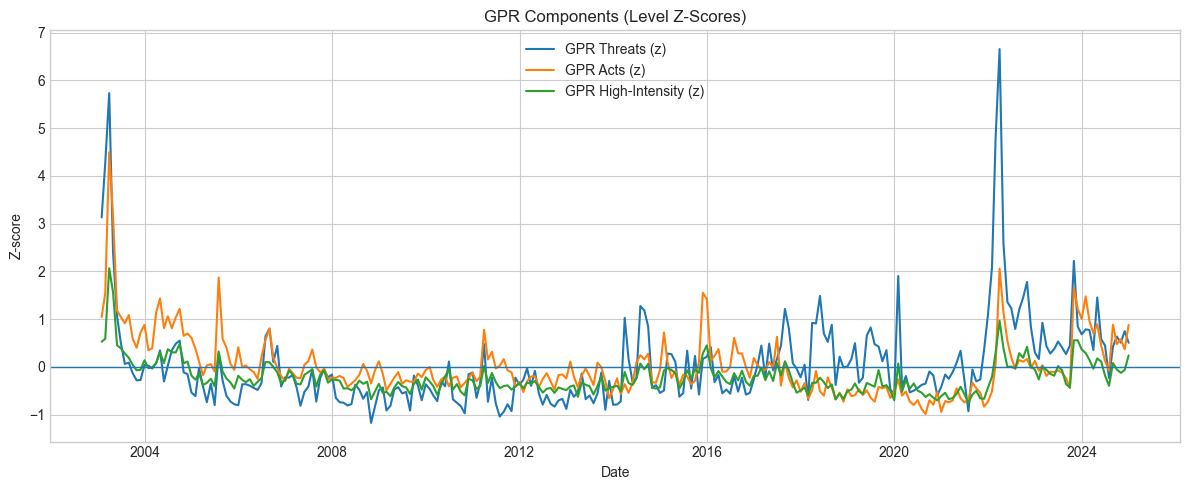

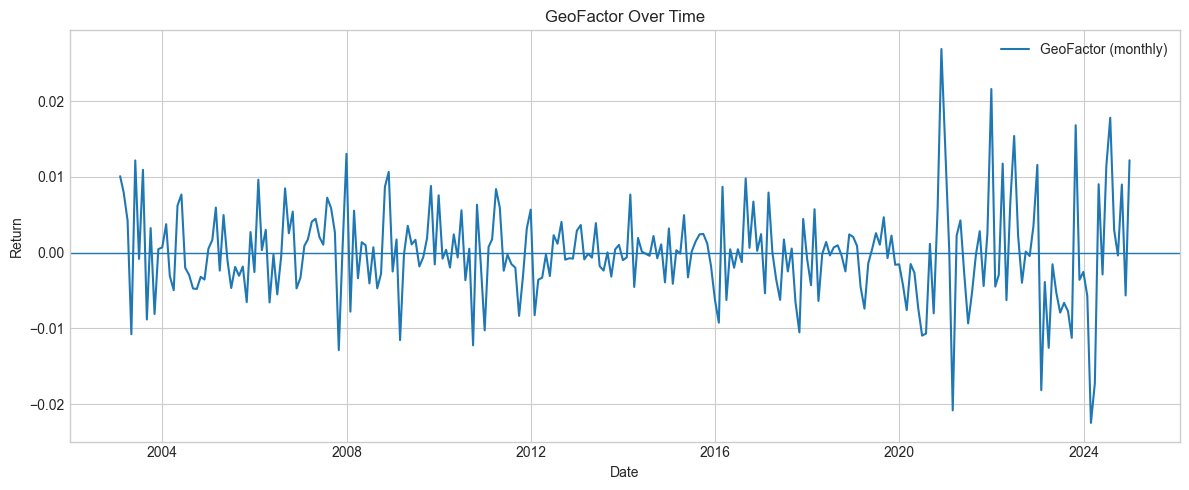

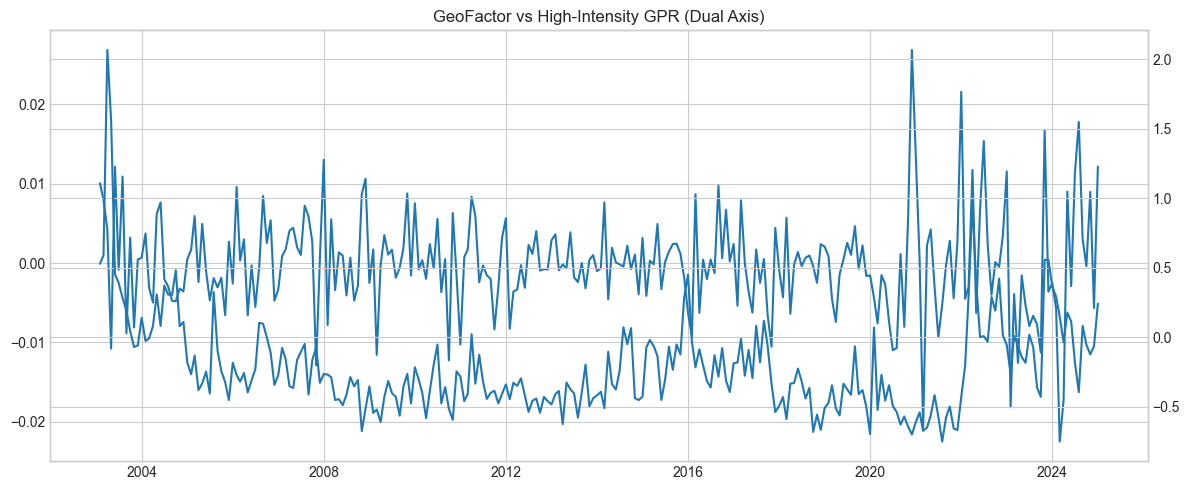

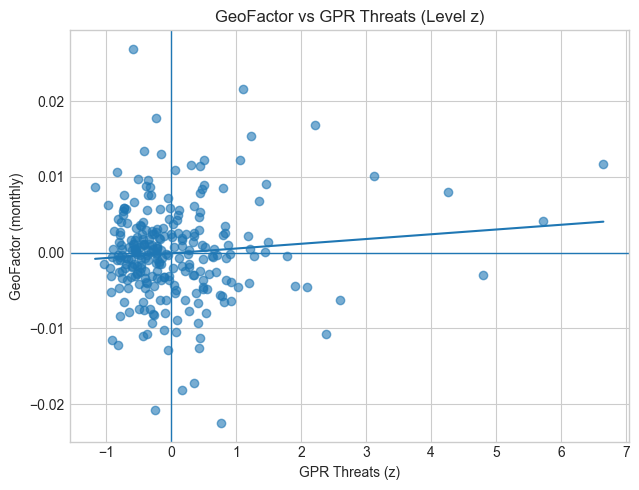

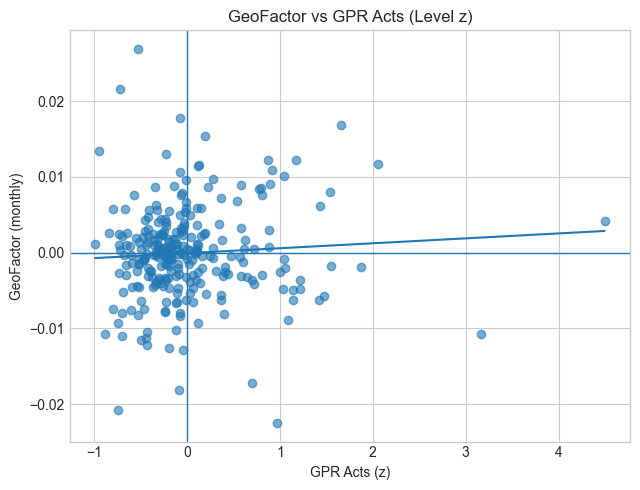

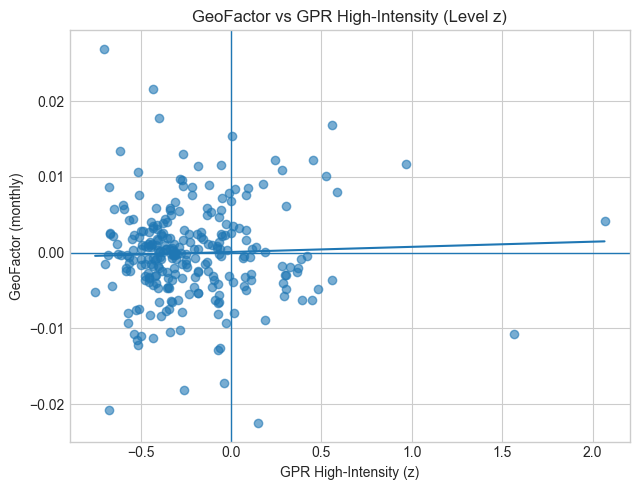

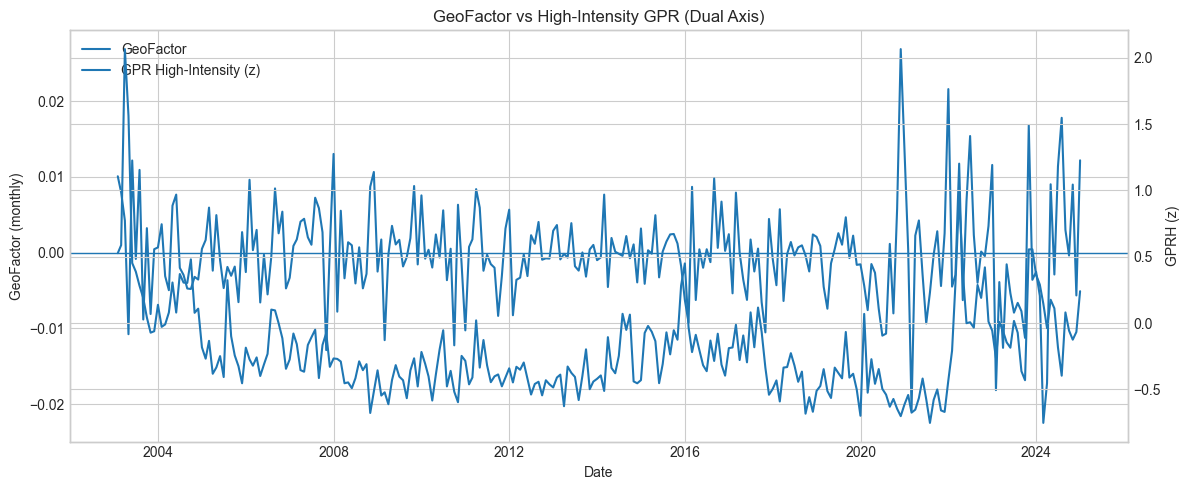

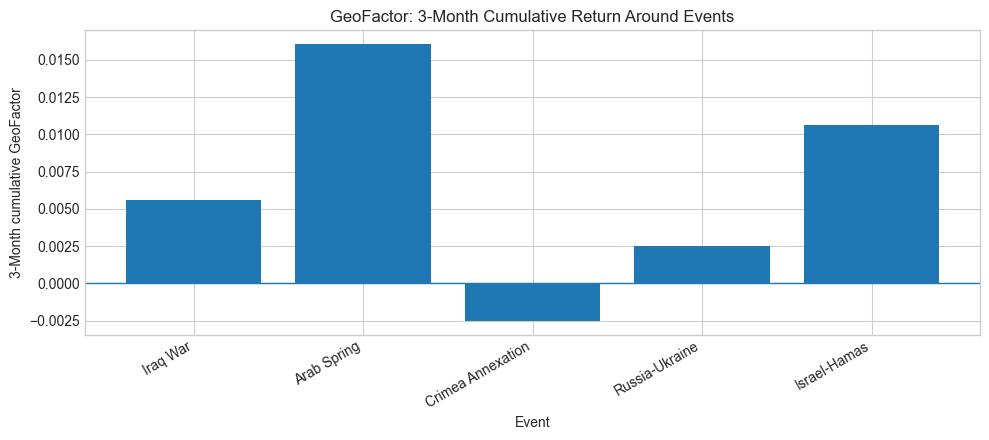

Optional comparison plot skipped (df_oos / df_oos_T / df_oos_A not all found).
Reason: "['date'] not in index"


In [84]:
#visualization block
viz = df_val.copy()
viz["date"] = pd.to_datetime(viz["date"]) + MonthEnd(0)
viz = viz.sort_values("date")

# ---------- 1) Time-series: Threats/Acts/High (levels z) ----------
plt.figure(figsize=(12, 5))
plt.plot(viz["date"], viz["gpr_threats_z"], label="GPR Threats (z)")
plt.plot(viz["date"], viz["gpr_acts_z"], label="GPR Acts (z)")
plt.plot(viz["date"], viz["gpr_high_z"], label="GPR High-Intensity (z)")
plt.axhline(0, linewidth=1)
plt.title("GPR Components (Level Z-Scores)")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 2) Time-series: GeoFactor vs GPR High-Intensity (level z) ----------
plt.figure(figsize=(12, 5))
plt.plot(viz["date"], viz["GeoFactor"], label="GeoFactor (monthly)")
plt.axhline(0, linewidth=1)
plt.title("GeoFactor Over Time")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(viz["date"], viz["GeoFactor"], label="GeoFactor (monthly)")
plt.twinx()
plt.plot(viz["date"], viz["gpr_high_z"], label="GPR High-Intensity (z)")
plt.title("GeoFactor vs High-Intensity GPR (Dual Axis)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# ---------- 3) Scatter: GeoFactor vs Threats/Acts/High ----------
def scatter_with_fit(x, y, xlab, ylab, title):
    df = pd.DataFrame({"x": x, "y": y}).dropna()
    plt.figure(figsize=(6.5, 5))
    plt.scatter(df["x"], df["y"], alpha=0.6)
    # OLS fit line (simple)
    if len(df) >= 10:
        b1, b0 = np.polyfit(df["x"], df["y"], 1)
        xs = np.linspace(df["x"].min(), df["x"].max(), 200)
        plt.plot(xs, b1*xs + b0)
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.tight_layout()
    plt.show()

scatter_with_fit(
    viz["gpr_threats_z"], viz["GeoFactor"],
    "GPR Threats (z)", "GeoFactor (monthly)",
    "GeoFactor vs GPR Threats (Level z)"
)

scatter_with_fit(
    viz["gpr_acts_z"], viz["GeoFactor"],
    "GPR Acts (z)", "GeoFactor (monthly)",
    "GeoFactor vs GPR Acts (Level z)"
)

scatter_with_fit(
    viz["gpr_high_z"], viz["GeoFactor"],
    "GPR High-Intensity (z)", "GeoFactor (monthly)",
    "GeoFactor vs GPR High-Intensity (Level z)"
)

# ---------- 4) Regime plot: Average GeoFactor by High-Intensity bins ----------
# (shows whether GeoFactor is higher when GPRH is high)
viz = df_val.copy()
viz["date"] = pd.to_datetime(viz["date"], errors="coerce") + MonthEnd(0)
viz = viz.sort_values("date")

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(viz["date"], viz["GeoFactor"], label="GeoFactor")
ax1.axhline(0, linewidth=1)
ax1.set_xlabel("Date")
ax1.set_ylabel("GeoFactor (monthly)")

ax2 = ax1.twinx()
ax2.plot(viz["date"], viz["gpr_high_z"], label="GPR High-Intensity (z)")
ax2.set_ylabel("GPRH (z)")

# combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("GeoFactor vs High-Intensity GPR (Dual Axis)")
plt.tight_layout()
plt.show()

# ---------- 5) Event-window bar charts (GeoFactor 3-month cumulative) ----------
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

def event_3m_table(df, factor_col):
    d = df.set_index("date").sort_index()
    rows = []
    for nm, ds in events.items():
        ed = pd.Timestamp(ds) + MonthEnd(0)
        if ed not in d.index:
            continue
        loc = d.index.get_loc(ed)
        cum3 = d.iloc[loc:loc+3][factor_col].sum() if loc + 3 <= len(d) else np.nan
        rows.append({"Event": nm, "Date": ed.date(), "Cum3": cum3})
    return pd.DataFrame(rows).sort_values("Date")

evt = event_3m_table(viz, "GeoFactor").dropna(subset=["Cum3"])

plt.figure(figsize=(10, 4.5))
plt.bar(evt["Event"], evt["Cum3"])
plt.axhline(0, linewidth=1)
plt.title("GeoFactor: 3-Month Cumulative Return Around Events")
plt.xlabel("Event")
plt.ylabel("3-Month cumulative GeoFactor")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ---------- 6) (Optional) Compare rebuilt factors: Original vs Threats-built vs Acts-built ----------
# If you have df_oos (original), df_oos_T (threats-built), df_oos_A (acts-built), this will work.
try:
    comp = df_oos[["date", "GeoFactor"]].copy()
    comp = comp.merge(df_oos_T[["date", "GeoFactor_T"]], on="date", how="inner")
    comp = comp.merge(df_oos_A[["date", "GeoFactor_A"]], on="date", how="inner")
    comp["date"] = pd.to_datetime(comp["date"]) + MonthEnd(0)
    comp = comp.sort_values("date").set_index("date")

    # cumulative (simple sum of monthly returns, not compounded)
    comp_cum = comp.cumsum()

    plt.figure(figsize=(12, 5))
    for c in comp_cum.columns:
        plt.plot(comp_cum.index, comp_cum[c], label=c)
    plt.axhline(0, linewidth=1)
    plt.title("Cumulative (Sum) Returns: Original vs Threats-built vs Acts-built")
    plt.xlabel("Date")
    plt.ylabel("Cumulative return (sum)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Optional comparison plot skipped (df_oos / df_oos_T / df_oos_A not all found).")
    print("Reason:", e)


Common sample months: 263 | start: 2003-02-28 | end: 2024-12-31


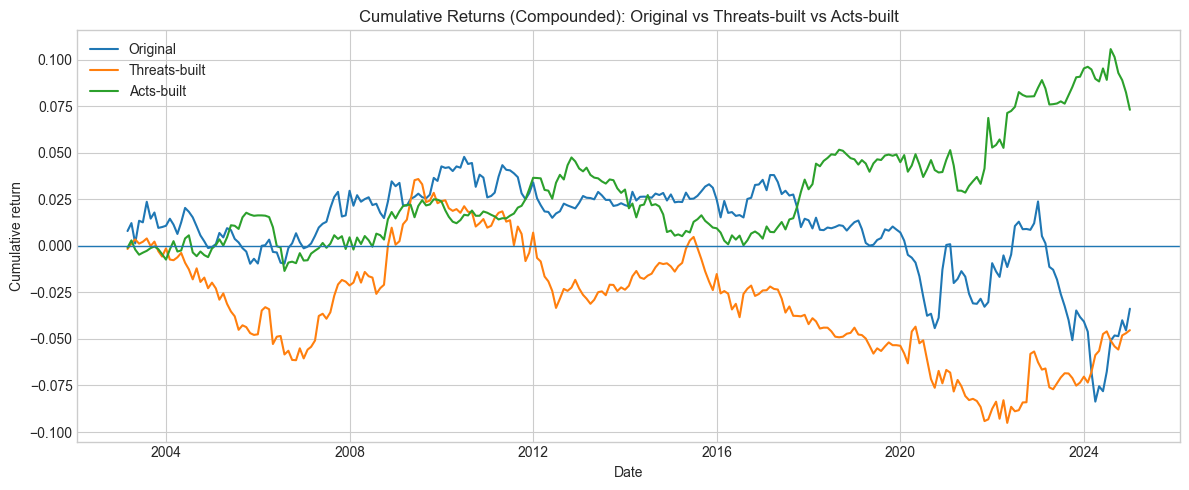

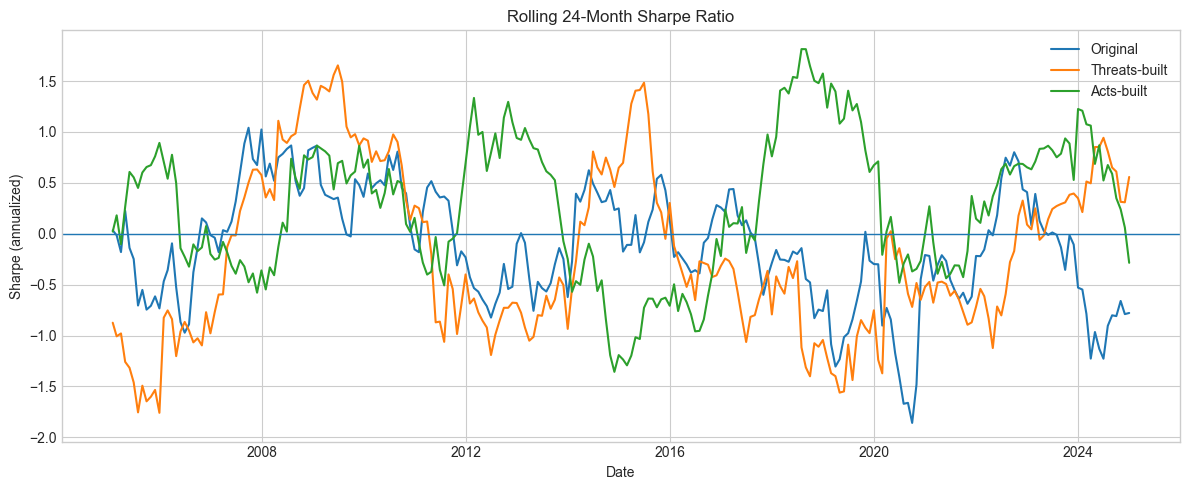

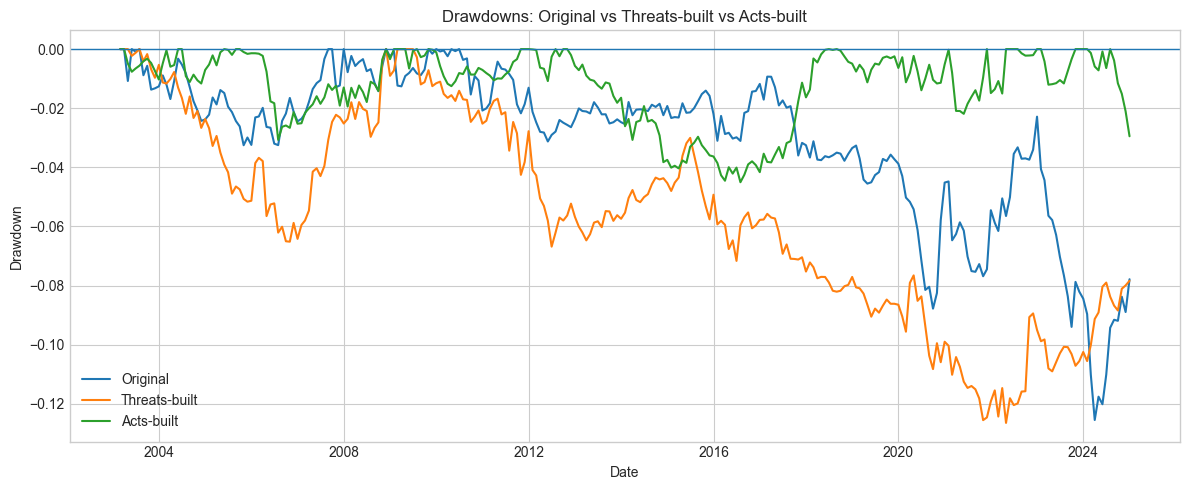

Events available in common sample: ['Iraq War', 'Arab Spring', 'Crimea Annexation', 'Russia-Ukraine', 'Israel-Hamas']


,Event,Date,Original_3Mo,Threats_3Mo,Acts_3Mo
0,Iraq War,2003-03-31,0.005609,0.002857,-0.003779
1,Arab Spring,2011-02-28,0.016054,0.007635,-0.001815
2,Crimea Annexation,2014-03-31,-0.002515,-0.001449,-0.000486
3,Russia-Ukraine,2022-02-28,0.002510,-0.012303,0.016311
4,Israel-Hamas,2023-10-31,0.010646,0.000800,0.009203


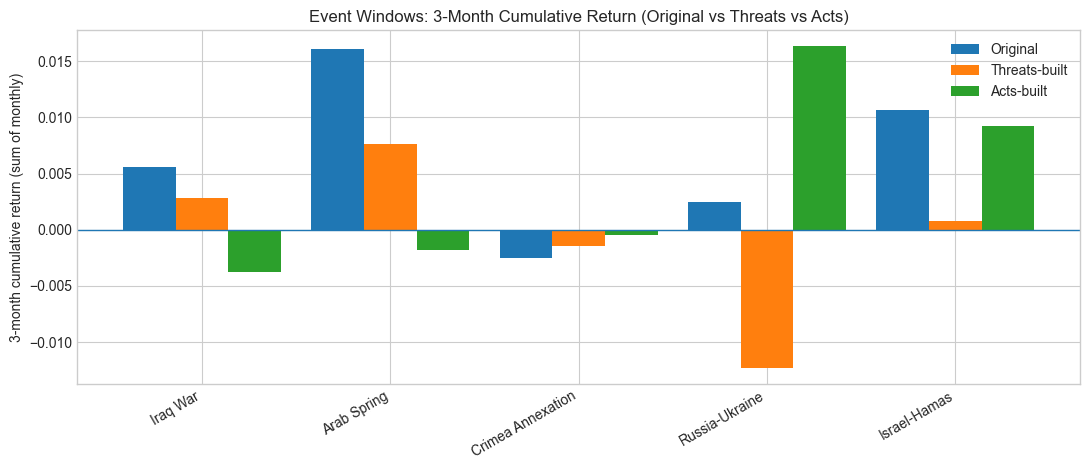

In [85]:

def to_month_end(s):
    return pd.to_datetime(s, errors="coerce") + MonthEnd(0)

def prep_factor(df, date_col, ret_col, new_name):
    d = df.copy()
    if date_col not in d.columns:
        # try index -> column
        d = d.reset_index()
        if date_col not in d.columns:
            # rename first column to date as fallback
            d = d.rename(columns={d.columns[0]: date_col})
    d[date_col] = to_month_end(d[date_col])
    d = d[[date_col, ret_col]].dropna().rename(columns={ret_col: new_name})
    return d.sort_values(date_col)

def compounded_cumret(r):
    return (1 + r).cumprod() - 1

def drawdown(r):
    wealth = (1 + r).cumprod()
    peak = wealth.cummax()
    return wealth / peak - 1

def rolling_sharpe(r, window=24):
    # annualized Sharpe from monthly returns
    mu = r.rolling(window).mean() * 12
    sd = r.rolling(window).std(ddof=0) * np.sqrt(12)
    return mu / sd

# -----------------------------
# 1) Build common-sample comparison frame
# -----------------------------
orig = prep_factor(df_oos,   "date", "GeoFactor",   "Original")
thrt = prep_factor(df_oos_T, "date", "GeoFactor_T", "Threats-built")
acts = prep_factor(df_oos_A, "date", "GeoFactor_A", "Acts-built")

comp = orig.merge(thrt, on="date", how="inner").merge(acts, on="date", how="inner")
comp = comp.set_index("date").sort_index()

print("Common sample months:", len(comp), "| start:", comp.index.min().date(), "| end:", comp.index.max().date())

# -----------------------------
# FIGURE 1: Compounded cumulative returns (best “headline” graph)
# -----------------------------
cum = compounded_cumret(comp)

plt.figure(figsize=(12, 5))
for c in cum.columns:
    plt.plot(cum.index, cum[c], label=c)
plt.axhline(0, linewidth=1)
plt.title("Cumulative Returns (Compounded): Original vs Threats-built vs Acts-built")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# FIGURE 2: Rolling Sharpe (shows regime dependence)
# -----------------------------
roll = pd.DataFrame({c: rolling_sharpe(comp[c], window=24) for c in comp.columns})

plt.figure(figsize=(12, 5))
for c in roll.columns:
    plt.plot(roll.index, roll[c], label=c)
plt.axhline(0, linewidth=1)
plt.title("Rolling 24-Month Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe (annualized)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# FIGURE 3: Drawdowns (risk story)
# -----------------------------
dd = pd.DataFrame({c: drawdown(comp[c]) for c in comp.columns})

plt.figure(figsize=(12, 5))
for c in dd.columns:
    plt.plot(dd.index, dd[c], label=c)
plt.axhline(0, linewidth=1)
plt.title("Drawdowns: Original vs Threats-built vs Acts-built")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# FIGURE 4: Event windows — grouped bars comparing all 3 (report-friendly)
# -----------------------------
events = {
    'Gulf War': '1990-08-31',
    '9/11 Attacks': '2001-09-30',
    'Iraq War': '2003-03-31',
    'Arab Spring': '2011-02-28',
    'Crimea Annexation': '2014-03-31',
    'Russia-Ukraine': '2022-02-28',
    'Israel-Hamas': '2023-10-31'
}

def event_table_from_comp(comp_df, events_dict):
    d = comp_df.copy()
    rows = []
    for nm, ds in events_dict.items():
        ed = pd.Timestamp(ds) + MonthEnd(0)
        if ed not in d.index:
            continue
        loc = d.index.get_loc(ed)
        if loc + 3 > len(d):
            continue
        cum3 = d.iloc[loc:loc+3].sum()  # sum of monthly returns (your existing convention)
        rows.append({
            "Event": nm,
            "Date": ed.date(),
            "Original_3Mo": float(cum3["Original"]),
            "Threats_3Mo": float(cum3["Threats-built"]),
            "Acts_3Mo": float(cum3["Acts-built"]),
        })
    out = pd.DataFrame(rows).sort_values("Date")
    return out

evt = event_table_from_comp(comp, events)

print("Events available in common sample:", evt["Event"].tolist())
display(evt)

x = np.arange(len(evt))
w = 0.28

plt.figure(figsize=(11, 4.8))
plt.bar(x - w, evt["Original_3Mo"], width=w, label="Original")
plt.bar(x,      evt["Threats_3Mo"], width=w, label="Threats-built")
plt.bar(x + w,  evt["Acts_3Mo"],    width=w, label="Acts-built")
plt.axhline(0, linewidth=1)
plt.xticks(x, evt["Event"], rotation=30, ha="right")
plt.title("Event Windows: 3-Month Cumulative Return (Original vs Threats vs Acts)")
plt.ylabel("3-month cumulative return (sum of monthly)")
plt.legend()
plt.tight_layout()
plt.show()


Common sample months: 263 | start: 2003-02-28 | end: 2024-12-31


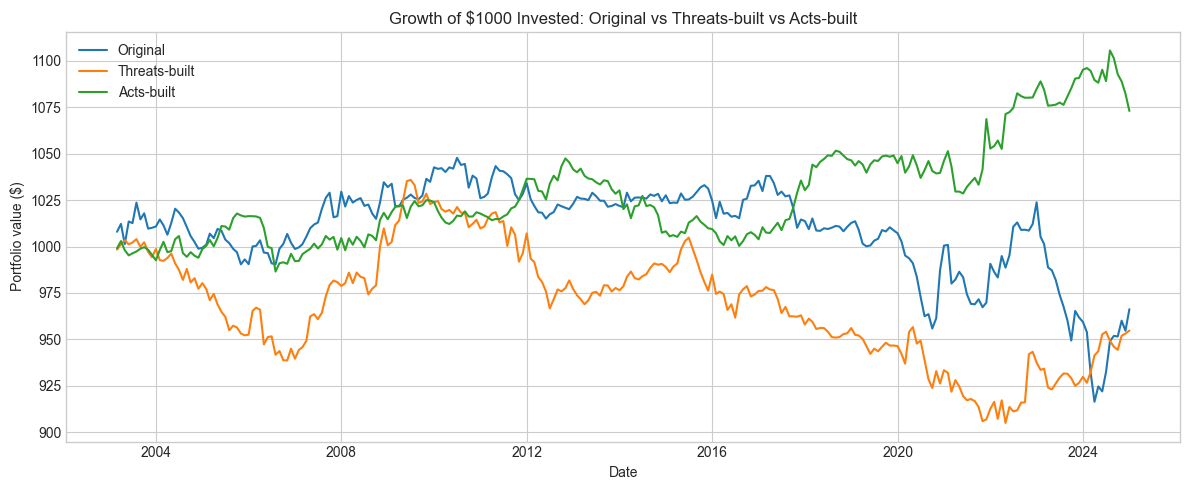

NameError: name 'port_rets_clean' is not defined

In [86]:

def to_month_end(s):
    return pd.to_datetime(s, errors="coerce") + MonthEnd(0)

def prep_factor(df, date_col, ret_col, new_name):
    d = df.copy()
    if date_col not in d.columns:
        d = d.reset_index()
        if date_col not in d.columns:
            d = d.rename(columns={d.columns[0]: date_col})
    d[date_col] = to_month_end(d[date_col])
    d = d[[date_col, ret_col]].dropna().rename(columns={ret_col: new_name})
    return d.sort_values(date_col)

def wealth_index(r, start=1000.0):
    # r is a pandas Series of monthly returns in decimal form
    return start * (1 + r).cumprod()

def drawdown(r):
    w = (1 + r).cumprod()
    peak = w.cummax()
    return w / peak - 1

def rolling_sharpe(r, window=24):
    mu = r.rolling(window).mean() * 12
    sd = r.rolling(window).std(ddof=0) * np.sqrt(12)
    return mu / sd

# ============================================================
# 0) Build common-sample comparison frame (Original / Threats / Acts)
# ============================================================
orig = prep_factor(df_oos,   "date", "GeoFactor",   "Original")
thrt = prep_factor(df_oos_T, "date", "GeoFactor_T", "Threats-built")
acts = prep_factor(df_oos_A, "date", "GeoFactor_A", "Acts-built")

comp = orig.merge(thrt, on="date", how="inner").merge(acts, on="date", how="inner")
comp = comp.set_index("date").sort_index()

print("Common sample months:", len(comp), "| start:", comp.index.min().date(), "| end:", comp.index.max().date())

# ============================================================
# PLOT 1: $1000 invested growth (Original vs Threats vs Acts)
# ============================================================
wealth3 = pd.DataFrame({c: wealth_index(comp[c], start=1000.0) for c in comp.columns})

plt.figure(figsize=(12, 5))
for c in wealth3.columns:
    plt.plot(wealth3.index, wealth3[c], label=c)
plt.title("Growth of $1000 Invested: Original vs Threats-built vs Acts-built")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 1) Add Naive Hedges (P10-P1 spreads)
#   Requires: port_rets_clean (baseline), port_T, port_A already exist
# ============================================================
def naive_spread(port_wide, name):
    d = port_wide.copy()
    # ensure date index
    if "date" in d.columns:
        d["date"] = to_month_end(d["date"])
        d = d.set_index("date")
    if not isinstance(d.index, pd.DatetimeIndex):
        d = d.reset_index().rename(columns={d.columns[0]: "date"})
        d["date"] = to_month_end(d["date"])
        d = d.set_index("date")
    d = d.sort_index()
    # spread
    return (d["P10"] - d["P1"]).rename(name)

# Baseline naive hedge (built from original beta sorts)
naive_orig = naive_spread(port_rets_clean, "Naive (Original P10-P1)")

# Naive hedges for Threats and Acts (built from the rebuilt deciles)
naive_T = naive_spread(port_T, "Naive Threats (P10-P1)")
naive_A = naive_spread(port_A, "Naive Acts (P10-P1)")

# ============================================================
# PLOT 2: $1000 growth including GeoFactors + Naive hedges
#   Use a common sample across all series so the comparison is fair
# ============================================================
all_series = pd.concat(
    [
        comp["Original"],
        comp["Threats-built"],
        comp["Acts-built"],
        naive_orig,
        naive_T,
        naive_A
    ],
    axis=1
).dropna().sort_index()

print("Common sample incl. naive hedges:", len(all_series),
      "| start:", all_series.index.min().date(),
      "| end:", all_series.index.max().date())

wealth_all = all_series.apply(lambda s: wealth_index(s, start=1000.0))

plt.figure(figsize=(12, 5))
for c in wealth_all.columns:
    plt.plot(wealth_all.index, wealth_all[c], label=c)
plt.title("Growth of $1000 Invested: GeoFactors vs Naive Hedges")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.tight_layout()
plt.show()


GeoFactor common sample months: 263 | start: 2003-02-28 | end: 2024-12-31


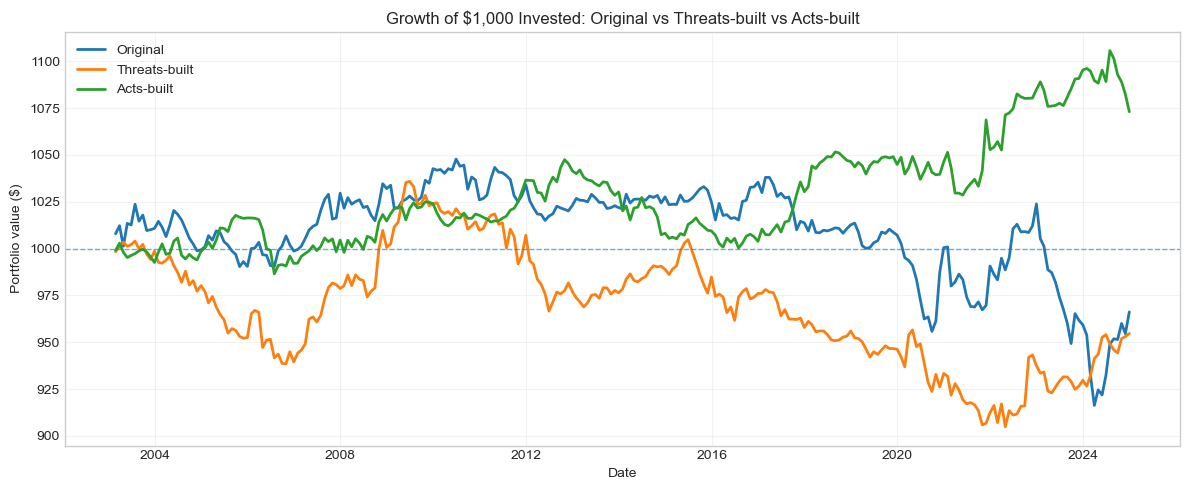

Common sample incl. naive hedges: 263 | start: 2003-02-28 | end: 2024-12-31


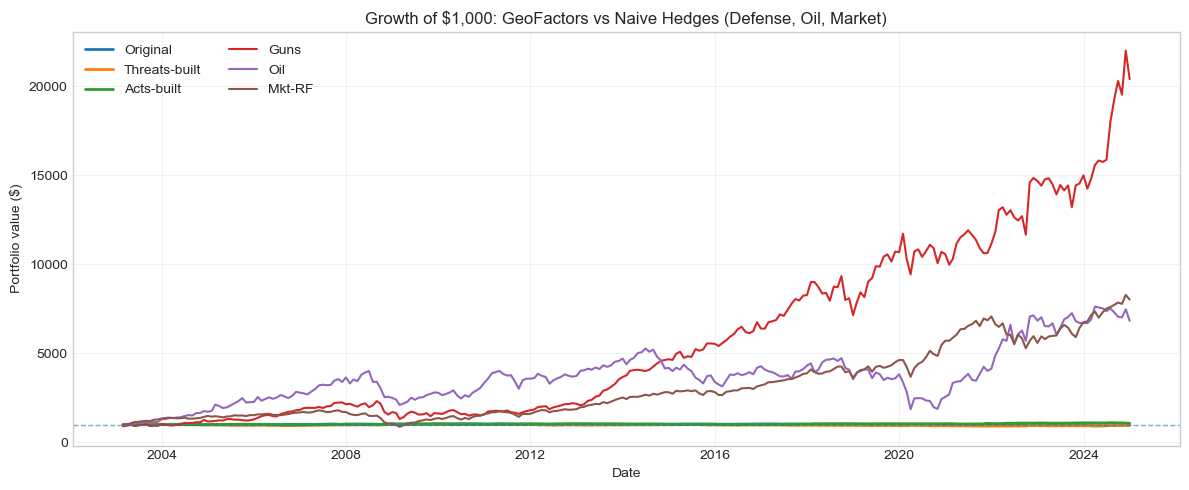

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

def to_month_end(s):
    return pd.to_datetime(s, errors="coerce") + MonthEnd(0)

def prep_factor(df, date_col, ret_col, new_name):
    d = df.copy()
    if date_col not in d.columns:
        d = d.reset_index()
        if date_col not in d.columns:
            d = d.rename(columns={d.columns[0]: date_col})
    d[date_col] = to_month_end(d[date_col])
    d = d[[date_col, ret_col]].dropna().rename(columns={ret_col: new_name})
    return d.sort_values(date_col)

def wealth_index(r, start=1000.0):
    return start * (1 + r).cumprod()

# ============================================================
# 0) Common-sample GeoFactors (Original / Threats / Acts)
# ============================================================
orig = prep_factor(df_oos,   "date", "GeoFactor",   "Original")
thrt = prep_factor(df_oos_T, "date", "GeoFactor_T", "Threats-built")
acts = prep_factor(df_oos_A, "date", "GeoFactor_A", "Acts-built")

comp = orig.merge(thrt, on="date", how="inner").merge(acts, on="date", how="inner")
comp = comp.set_index("date").sort_index()

print("GeoFactor common sample months:", len(comp),
      "| start:", comp.index.min().date(),
      "| end:", comp.index.max().date())

# ============================================================
# PLOT 1: $1000 growth (Original vs Threats vs Acts)
# ============================================================
wealth3 = pd.DataFrame({c: wealth_index(comp[c], start=1000.0) for c in comp.columns})

plt.figure(figsize=(12, 5))
for c in wealth3.columns:
    plt.plot(wealth3.index, wealth3[c], label=c, linewidth=2)
plt.axhline(1000, linestyle="--", linewidth=1, alpha=0.6)
plt.title("Growth of $1,000 Invested: Original vs Threats-built vs Acts-built")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend()
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: Add Naive Hedges from Cell 8 (Guns, Oil, Mkt-RF)
#   Uses df_val created in Cell 8 (df_val = df_oos merged with benchmarks)
# ============================================================
need_cols = ["date", "Guns", "Oil", "Mkt-RF"]
missing = [c for c in need_cols if c not in df_val.columns]

bench = df_val[need_cols].copy()
bench["date"] = to_month_end(bench["date"])
bench = bench.dropna().sort_values("date").set_index("date")

# Merge GeoFactors with benchmarks on common sample
all_series = comp.merge(bench, left_index=True, right_index=True, how="inner")

print("Common sample incl. naive hedges:", len(all_series),
      "| start:", all_series.index.min().date(),
      "| end:", all_series.index.max().date())

wealth_all = all_series.apply(lambda s: wealth_index(s, start=1000.0))

plt.figure(figsize=(12, 5))
for c in wealth_all.columns:
    # make GeoFactors thicker lines for readability
    lw = 2 if c in ["Original", "Threats-built", "Acts-built"] else 1.5
    plt.plot(wealth_all.index, wealth_all[c], label=c, linewidth=lw)

plt.axhline(1000, linestyle="--", linewidth=1, alpha=0.6)
plt.title("Growth of $1,000: GeoFactors vs Naive Hedges (Defense, Oil, Market)")
plt.xlabel("Date")
plt.ylabel("Portfolio value ($)")
plt.legend(ncol=2)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()
